# Генерация звука

В этом семинаре мы разберемся с моделью WaveNet от DeepMind.


*   Ссылка на оргинальную [статью](https://arxiv.org/abs/1609.03499).
*   Ссылка на [блог](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio).



In [1]:
!pip install torchaudio

     |████████████████████████████████| 1.9MB 12.5MB/s 


In [2]:
# Оформление 
from typing import List, Tuple, Dict, Union, Optional

# Картинки
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.display import clear_output

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

# Аудио
from IPython import display

import torchaudio
from torchaudio.transforms import MelSpectrogram

# Основное
import os
from tqdm import tqdm
from itertools import islice

import pandas as pd
import numpy as np
import math

import torch
from torch import distributions
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

from dataclasses import dataclass
import librosa

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Хотим по слову генерировать звук.

Для начала вспомним архитектуру сети:

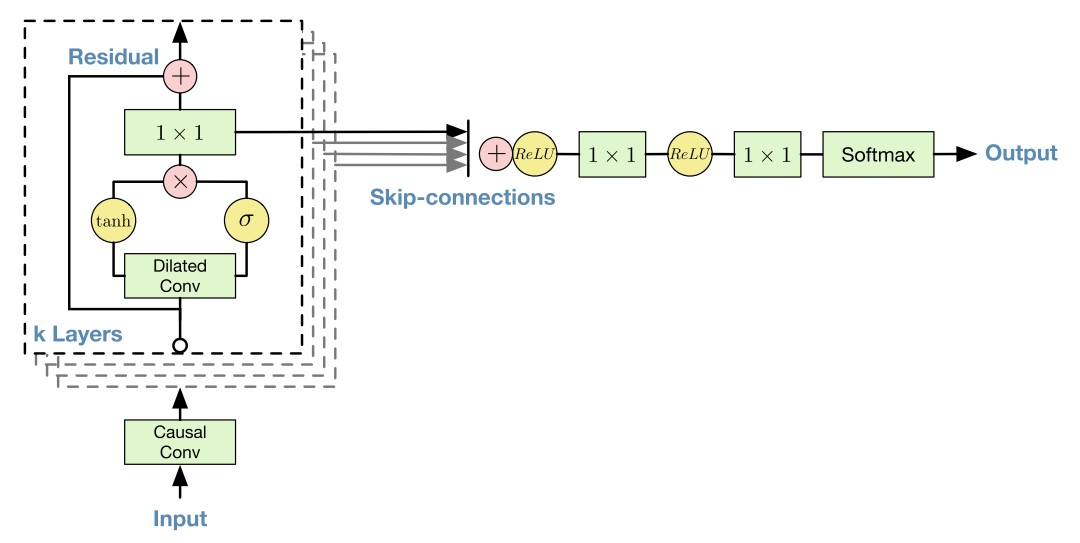



$p(x) = \prod\limits_{t=1}^{T} p(x_t|x_1, ..., x_{t-1})$

Теперь начнём разбираться со "строительными блоками" WaveNet.

## Causal Convolutional Layer
Первый на очереди **Causal Convolutional Layer**.
Основная идея в том, что при свертке мы не позволяем заглядывать сети в будущее, т.е. выход $k$-го слоя в момент времени $t$ зависит только от выходов $k-1$ слоя в моменты времени $t, t-1, t-2, \dots, 1,$ но не в моменты времени $t+1, t+2$ и т.д.

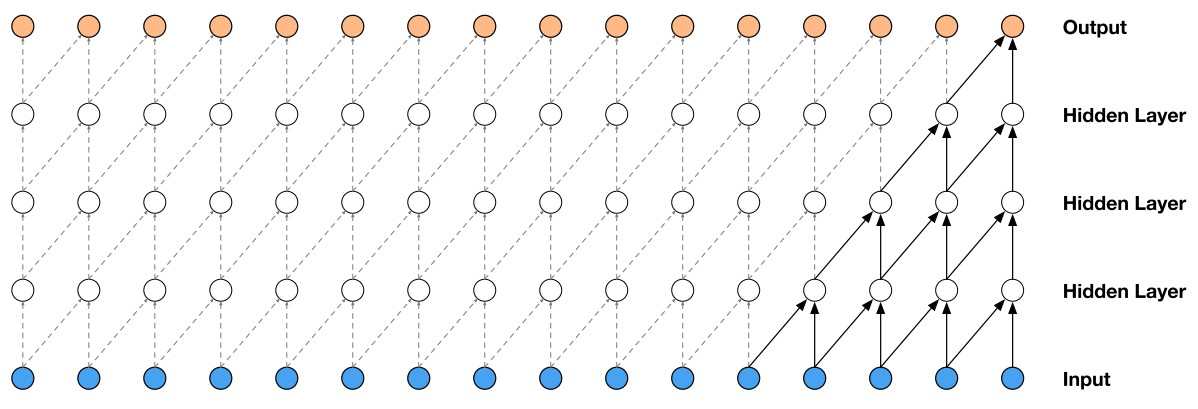

И его вариант **Dilated Causal Convolutional Layers**.

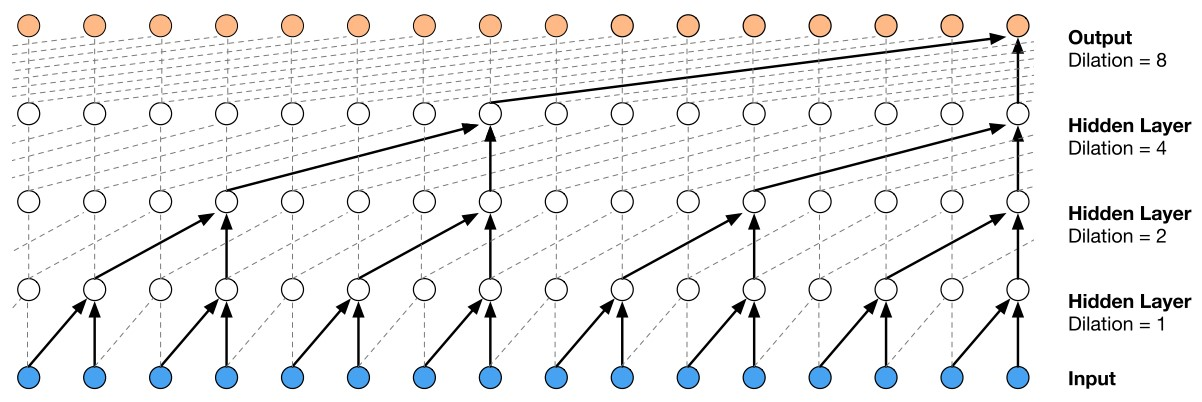

Здесь поле восприятия намного больше: 16 vs. 5. Следовательно, в такой реализации больше сэмплов влияют на выход.

Посмотрим как это реализуется в коде.

In [3]:
class CasualConv1d(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, bias=True) -> None:
        # Наследуем обычную свертку
        super().__init__(in_channels, out_channels, kernel_size, dilation=dilation, bias=bias)

        # Задаем, сколько сэмплов надо пропустить
        padding_size = (self.dilation[0] * (self.kernel_size[0] - 1), 0)

        # Заполняем нулями правую часть, где надо
        self.zero_padding = nn.ConstantPad1d(padding_size, 0.0)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        padded_input = self.zero_padding(input)
        output = super().forward(padded_input)

        return output

## Gated Activation Units

Теперь обратим внимание на эту часть сети

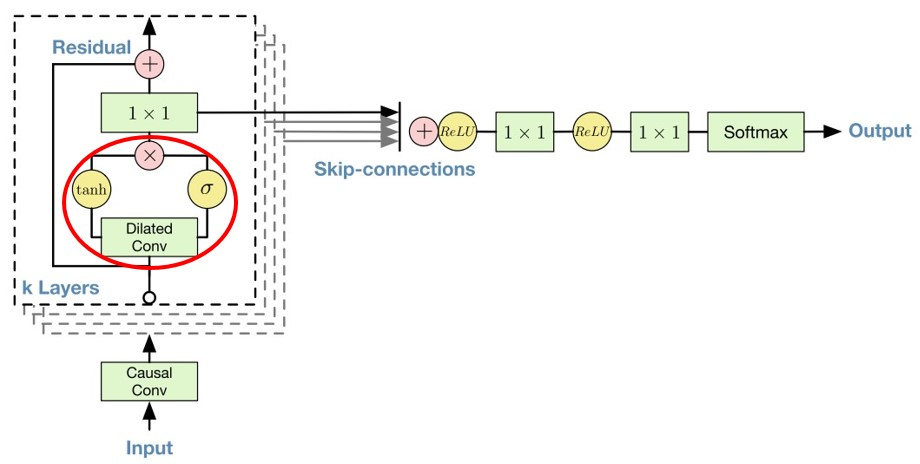

$z = \tanh\left(W_{f,k} x\right)\odot\sigma\left(V_{g,k}x\right)$

Авторы статье выбрали такую функцию активации, т.к. в экспериментах по генерации аудио сигнала она работала лучше чем ReLU.

Q: Почему?

A: Гиперболический тангенс дает вектор результатов, то есть генериует новые признаки в диапазоне $[-1, 1]$, а сигмойда задает вероятность каждого результата, его важность.

In [4]:
 class GatedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()

        self.filter_conv = CasualConv1d(in_channels, out_channels, kernel_size, dilation)
        self.gate_conv = CasualConv1d(in_channels, out_channels, kernel_size, dilation)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        filter_output = self.filter_conv(input)
        gate_output = self.gate_conv(input)
        output = torch.tanh(filter_output) * torch.sigmoid(gate_output)

        return output

Добавляя дополнительный вход — получаем условную вероятность — мы можем генерировать звук с определенными характеристиками. Например, для Text to Speech (TTS) нам нужно подавать информацию о тексте как дополнительный вход.

$p(x|h) = \prod\limits_{t=1}^{T} p(x_t|x_1, ..., x_{t-1},h)$

$z = \tanh\left(W_{f,k}x + V_{f,k}^T h\right)\odot\sigma\left(V_{g,k}x + V_{g,k}^T h\right)$

In [5]:
class CondGatedConv1d(GatedConv1d):
    def __init__(self, in_channels, out_channels, cond_in_channels, kernel_size, dilation):
        super().__init__(in_channels, out_channels, kernel_size, dilation)

        self.cond_conv = nn.Conv1d(cond_in_channels, 2 * out_channels, kernel_size=1)

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        filter_output = self.filter_conv(input)
        gate_output = self.gate_conv(input)
        condition_output = self.cond_conv(condition)

        t = filter_output.size()[-1]
        condition_output = condition_output[:, :, :t]

        condition_filter, condition_gate = torch.chunk(condition_output, chunks=2, dim=CHANNEL)

        output = torch.tanh(filter_output + condition_filter) * torch.sigmoid(gate_output + condition_gate)

        return output

## Residual Block

Из уже описанных блоков давайте соберём **Residual Block**.

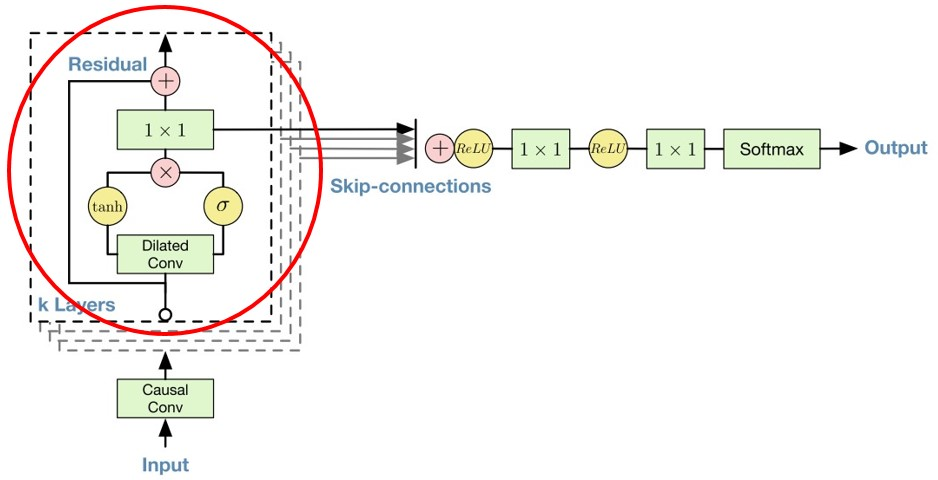

In [6]:
class CondWaveNetBlock(nn.Module):
    """
    Conditioned WaveNet block
    """

    def __init__(self, gated_in_channels, gated_out_channels, cond_in_channels,
                 skip_out_channels, kernel_size, dilation):
        super().__init__()

        self.skip_conv = nn.Conv1d(gated_out_channels, skip_out_channels, kernel_size=1)
        self.residual_conv = nn.Conv1d(gated_out_channels, gated_in_channels, kernel_size=1)
        self.gated_cond = CondGatedConv1d(gated_in_channels, gated_out_channels,
                                          cond_in_channels, kernel_size, dilation)

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        gate_output = self.gated_cond(input, condition)
        residual_output = input + self.residual_conv(gate_output)
        residual_output *= math.sqrt(0.5)  # trick from ConvS22 for stabilize variance
        skip_output = self.skip_conv(gate_output)

        return residual_output, skip_output

## Mu Law

Ещё один важный элемент архитектуры — это $\mu$-закон.

$f(x_t) = sign(x_t)\dfrac{\ln(1 + \mu |x_t|)}{\ln(1 + \mu)}$

Поскольку необработанный звук обычно хранится как последовательность $16$-битных целочисленных значений (по одному на timestep), слою softmax потребуется выводить $65 536$ вероятностей на каждом timestep. Применение сначала $\mu$-закона, а потом квантинизации до $256$ значений облегчает обработку.

In [7]:
class MuLaw(nn.Module):

    def __init__(self, mu: float = 256):
        super().__init__()
        self.register_buffer('mu', torch.FloatTensor([mu - 1]))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        input = torch.clamp(input, -1 + 1e-5, 1 - 1e-5)

        mu_law_output = torch.sign(input) * torch.log1p(self.mu * torch.abs(input)) / torch.log1p(self.mu)

        # Переводим отрезок [-1, 1] в [0, 1]
        quantized_output = (mu_law_output + 1) / 2

        # [0, 1] -> [0, mu - 1]
        quantized_output = torch.floor(quantized_output * self.mu + 0.5).long()

        return quantized_output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        dequantized_output = (input.float() / self.mu) * 2 - 1
        output = (torch.sign(dequantized_output) / self.mu) * ((1 + self.mu) ** torch.abs(dequantized_output) - 1)

        return output

In [8]:
# Вспомогательный класс для кодирования классов 

class OneHot(nn.Module):
    """
    Convert quantized 1d samples into n_class one-hot tensor
    """

    def __init__(self, n_class: int = 256):
        super().__init__()

        self.n_class = n_class

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.dim() == 3, "Expected shape of inout is [B, C, T], where C == 1"
        return self.encode(input)

    def encode(self, input: torch.Tensor) -> torch.Tensor:
        output = torch.zeros(input.size(0), self.n_class, input.size(-1), device=input.device)
        output.scatter_(1, input, 1)
        return output

    def decode(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

## WaveNet

Теперь соберем всю сеть.

In [9]:
class CondNet(nn.Module):
    """
    Processing condition (mel from TTS or logits from ASR)
    """

    def __init__(self, input_size: int, hidden_size: int, hop_size: int):
        """
        :param input_size:
        """
        super().__init__()

        self.input_size = input_size
        self.hop_size = hop_size
        self.hidden_size = hidden_size

        self.net = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size // 2,
                          num_layers=2,
                          batch_first=True,
                          bidirectional=True)
        
        self.upsampler = nn.Upsample(scale_factor=hop_size, mode='nearest')

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        :param input: logits from ASR encoder, input.shape == [B, T, C]

        :return: .shape == [B, T', C']

        """
        assert input.shape[-1] == self.input_size

        self.net.flatten_parameters()

        output, _ = self.net(input)

        output = output.transpose(-1, -2)
        upsampled_output = self.upsampler(output)

        return upsampled_output

In [10]:
class WaveNet(nn.Module):

    def __init__(
        self,
        # in_channels: int = 256,
        # out_channels: int = 256,
        # gate_channels: int = 512,
        # residual_channels: int = 256,
        # skip_channels: int = 256,
        # head_channels: int = 256,
        # condition_channels: int = 256,
        in_channels: int = 64,
        out_channels: int = 64,
        gate_channels: int = 64,
        residual_channels: int = 64,
        skip_channels: int = 64,
        head_channels: int = 64,
        condition_channels: int = 64,
        kernel_size: int = 2,
        dilation_cycles: int = 3,
        dilation_depth: int = 10,
        upsample_factor: int = 480,
    ) -> None:
        """
        :param kernel_size (int):
        """

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.gate_channels = gate_channels
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.head_channels = head_channels
        self.condition_channels = condition_channels
        self.kernel_size = kernel_size
        self.dilation_cycles = dilation_cycles
        self.dilation_depth = dilation_depth
        self.upsample_factor = upsample_factor

        # 80 — number of channels in mels 
        self.cond = CondNet(80, self.condition_channels, upsample_factor)

        self.stem = nn.Sequential(nn.Conv1d(in_channels, residual_channels, kernel_size=1))

        # WaveNet blocks
        self.blocks = nn.ModuleList([CondWaveNetBlock(residual_channels, gate_channels, condition_channels, 
                                                      skip_channels, kernel_size, 2 ** (i % dilation_depth))
                                     for i in range(dilation_cycles * dilation_depth)])

        # To avoid DDP error
        self.blocks[-1].residual_conv.requires_grad_(False)

        self.head = nn.Sequential(nn.ReLU(inplace=True),
                                  nn.Conv1d(skip_channels, head_channels, kernel_size=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv1d(head_channels, out_channels, kernel_size=1))

    def _forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        # already upsampled condition
        stem_output = self.stem(input)

        accumulation = 0
        residual_output = stem_output
        for i, block in enumerate(self.blocks):
            residual_output, skip_output = block(residual_output, condition)
            accumulation = accumulation + skip_output

        output = self.head(accumulation)

        return output

    def forward(self, input: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        """
        :param input: samples
        :param condition: mel
        """

        condition = self.cond(condition)
        output = self._forward(input, condition)

        return output

    @property
    def num_parameters(self) -> int:
        return sum([p.numel() for p in self.parameters()])

    @property
    def receptive_field(self) -> int:
        dilations = [2 ** (i % self.dilation_depth)
                     for i in range(self.dilation_cycles * self.dilation_depth)]
        receptive_field = (self.kernel_size - 1) * sum(dilations) + 1

        return receptive_field

    def generate(self, condition: torch.Tensor, inference_type: str = "naive", verbose: bool = True) -> torch.Tensor:
        """
        :param condition: [1, T, C], C from ASR
        :param inference_type:
        :param verbose:
        """

        mu_low = MuLaw().to(condition.device)

        if inference_type == "naive":
            compressed_samples = self._naive_generate(condition, verbose)
        elif inference_type == "fast":
            compressed_samples = self._fast_generate(condition)
        else:
            raise ValueError(f"Invalid type of inference: {inference_type}")

        return mu_low.decode(compressed_samples)

    @torch.no_grad()
    def _naive_generate(self, condition: torch.Tensor, verbose: bool) -> torch.Tensor:
        one_hot = OneHot()

        required_num_samples = condition.shape[1] * self.upsample_factor
        generated_samples = torch.Tensor(1, 1, self.receptive_field + required_num_samples) \
            .fill_(self.in_channels // 2) \
            .to(condition.device)

        condition = self.cond(condition)
        condition = F.pad(condition, (self.receptive_field, 0), 'replicate')

        iterator = range(required_num_samples)
        if verbose:
            iterator = tqdm(iterator)

        for i in iterator:
            current_condition = condition[:, :, i:i + self.receptive_field]
            current_samples = generated_samples[:, :, i:i + self.receptive_field]
            current_one_hot_samples = one_hot(current_samples.long())

            current_output = self._forward(current_one_hot_samples, current_condition)
            last_logits = current_output[:, :, -1].squeeze()

            # sampling new sample
            samples = distributions.Categorical(logits=last_logits)
            new_sample = samples.sample(torch.Size([1]))
            generated_samples[:, :, i + self.receptive_field] = new_sample

        return generated_samples.squeeze()[-required_num_samples:]

## Data

Будем работать с датасетом [LJ Speech Dataset](https://keithito.com/LJ-Speech-Dataset/). Данные представляют из запись и её транскрипцию. По ссылке можно послушать примеры записей.

In [11]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xf LJSpeech-1.1.tar.bz2

--2021-04-05 17:15:48--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  36.8MB/s    in 76s     

2021-04-05 17:17:04 (34.5 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



Класс для преобразования из wav в mel.

In [12]:
@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0
        
    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()
        
        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))
    

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """
        
        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

Определим класс для датасета.

In [13]:
class LJSpeech(Dataset):
    def __init__(self, X, config=MelSpectrogramConfig(), train=True):
        super().__init__()
        self.names = X
        self.train = train
        self.config = config
        self.featurizer = MelSpectrogram(MelSpectrogramConfig())
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):       
        wav, sr = torchaudio.load('LJSpeech-1.1/wavs/' + self.names[idx] + '.wav')
        # wav = wav[:, :40000]    
        
        mel_spectrogram = self.featurizer(wav)
        sample = {'mel':mel_spectrogram.reshape(self.config.n_mels, -1),
                  'wav': wav}
         
        return sample

Загрузим метаданные.

In [14]:
df = pd.read_csv("/content/LJSpeech-1.1/metadata.csv", names=['id', 'gt', 'gt_letters_only'], sep="|")
df = df.dropna()
data = list(df['id'])

In [15]:
train_dataset = LJSpeech(data)
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
BATCH, CHANNEL, TIME = 0, 1, 2

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = WaveNet().to(device)
# mu_law = MuLaw(256).to(device)
# one_hot = OneHot(256).to(device)
mu_law = MuLaw(64).to(device)
one_hot = OneHot(64).to(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)

In [20]:
num_epoch = 3

for epoch in range(num_epoch):
        
        model.train()
        for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            global_step = epoch * len(train_dataloader) + i
            optimizer.zero_grad()

            samples = batch['wav'].to(device)
            mel = batch['mel'].to(device)
            
            categorical_samples = mu_law(samples)
            one_hot_samples = one_hot(categorical_samples)
            mel = mel.transpose(2,1)
            prediction = model(one_hot_samples, mel)
            
            loss = criterion(prediction[:, :, :-1], categorical_samples.squeeze(dim=1)[:, 1:])
            loss.backward()
            
            optimizer.step()
            
            # Print loss
            if i % 50 == 0:
              print("Loss: ", loss.item())       

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 2/13084 [00:00<2:07:59,  1.70it/s]

Loss:  4.19251012802124


  0%|          | 51/13084 [00:21<1:24:29,  2.57it/s]

Loss:  3.8933801651000977


  1%|          | 101/13084 [00:42<1:41:09,  2.14it/s]

Loss:  3.7431068420410156


  1%|          | 151/13084 [01:02<1:24:48,  2.54it/s]

Loss:  3.6965134143829346


  2%|▏         | 201/13084 [01:22<1:39:58,  2.15it/s]

Loss:  3.387388229370117


  2%|▏         | 251/13084 [01:43<1:33:36,  2.28it/s]

Loss:  3.0610878467559814


  2%|▏         | 301/13084 [02:04<1:13:59,  2.88it/s]

Loss:  3.177053213119507


  3%|▎         | 351/13084 [02:24<1:14:34,  2.85it/s]

Loss:  2.949465036392212


  3%|▎         | 401/13084 [02:45<1:14:38,  2.83it/s]

Loss:  3.0216453075408936


  3%|▎         | 451/13084 [03:06<1:30:10,  2.33it/s]

Loss:  2.7520053386688232


  4%|▍         | 501/13084 [03:29<1:34:29,  2.22it/s]

Loss:  2.763887405395508


  4%|▍         | 551/13084 [03:51<1:20:20,  2.60it/s]

Loss:  2.382133722305298


  5%|▍         | 601/13084 [04:13<1:39:42,  2.09it/s]

Loss:  2.6973824501037598


  5%|▍         | 652/13084 [04:35<1:19:39,  2.60it/s]

Loss:  2.4661929607391357


  5%|▌         | 701/13084 [04:56<1:20:47,  2.55it/s]

Loss:  2.484161376953125


  6%|▌         | 751/13084 [05:17<1:14:17,  2.77it/s]

Loss:  2.7603280544281006


  6%|▌         | 801/13084 [05:39<1:21:05,  2.52it/s]

Loss:  2.3512051105499268


  7%|▋         | 851/13084 [06:00<1:23:45,  2.43it/s]

Loss:  2.0398638248443604


  7%|▋         | 901/13084 [06:22<1:23:41,  2.43it/s]

Loss:  2.104685068130493


  7%|▋         | 951/13084 [06:43<1:25:12,  2.37it/s]

Loss:  2.0729267597198486


  8%|▊         | 1001/13084 [07:04<1:19:13,  2.54it/s]

Loss:  2.0745890140533447


  8%|▊         | 1051/13084 [07:24<1:19:41,  2.52it/s]

Loss:  2.096956491470337


  8%|▊         | 1101/13084 [07:44<1:36:15,  2.07it/s]

Loss:  1.8444428443908691


  9%|▉         | 1151/13084 [08:06<1:15:27,  2.64it/s]

Loss:  2.0384395122528076


  9%|▉         | 1201/13084 [08:28<1:21:24,  2.43it/s]

Loss:  1.8227266073226929


 10%|▉         | 1251/13084 [08:49<1:15:54,  2.60it/s]

Loss:  1.8969725370407104


 10%|▉         | 1301/13084 [09:08<1:14:30,  2.64it/s]

Loss:  2.3158085346221924


 10%|█         | 1351/13084 [09:29<1:26:34,  2.26it/s]

Loss:  1.8463213443756104


 11%|█         | 1401/13084 [09:50<1:19:16,  2.46it/s]

Loss:  1.8720930814743042


 11%|█         | 1451/13084 [10:12<1:16:15,  2.54it/s]

Loss:  1.8442339897155762


 11%|█▏        | 1501/13084 [10:35<1:25:37,  2.25it/s]

Loss:  1.9011613130569458


 12%|█▏        | 1552/13084 [10:56<1:08:48,  2.79it/s]

Loss:  1.7046936750411987


 12%|█▏        | 1601/13084 [11:16<1:35:00,  2.01it/s]

Loss:  1.6362864971160889


 13%|█▎        | 1651/13084 [11:37<1:26:05,  2.21it/s]

Loss:  1.7907593250274658


 13%|█▎        | 1701/13084 [11:59<1:25:08,  2.23it/s]

Loss:  1.8390986919403076


 13%|█▎        | 1751/13084 [12:20<1:11:42,  2.63it/s]

Loss:  1.556579351425171


 14%|█▍        | 1802/13084 [12:43<1:14:10,  2.53it/s]

Loss:  1.6433781385421753


 14%|█▍        | 1851/13084 [13:04<1:21:39,  2.29it/s]

Loss:  1.6640642881393433


 15%|█▍        | 1901/13084 [13:27<1:24:30,  2.21it/s]

Loss:  1.59442138671875


 15%|█▍        | 1951/13084 [13:48<1:22:19,  2.25it/s]

Loss:  1.8067643642425537


 15%|█▌        | 2001/13084 [14:09<1:26:34,  2.13it/s]

Loss:  1.6046212911605835


 16%|█▌        | 2051/13084 [14:31<1:25:42,  2.15it/s]

Loss:  1.6008882522583008


 16%|█▌        | 2101/13084 [14:50<1:09:21,  2.64it/s]

Loss:  1.4845350980758667


 16%|█▋        | 2152/13084 [15:11<54:18,  3.36it/s]  

Loss:  1.8501248359680176


 17%|█▋        | 2201/13084 [15:32<1:17:09,  2.35it/s]

Loss:  1.5114384889602661


 17%|█▋        | 2252/13084 [15:52<56:52,  3.17it/s]  

Loss:  1.735904335975647


 18%|█▊        | 2301/13084 [16:13<57:01,  3.15it/s]  

Loss:  1.6198384761810303


 18%|█▊        | 2351/13084 [16:31<59:56,  2.98it/s]

Loss:  1.9316093921661377


 18%|█▊        | 2401/13084 [16:52<55:12,  3.23it/s]

Loss:  1.5648890733718872


 19%|█▊        | 2451/13084 [17:13<1:23:00,  2.13it/s]

Loss:  1.6396187543869019


 19%|█▉        | 2501/13084 [17:35<1:18:58,  2.23it/s]

Loss:  1.5232644081115723


 19%|█▉        | 2551/13084 [17:54<1:12:02,  2.44it/s]

Loss:  1.727396845817566


 20%|█▉        | 2601/13084 [18:14<1:09:30,  2.51it/s]

Loss:  1.625363826751709


 20%|██        | 2651/13084 [18:36<1:00:06,  2.89it/s]

Loss:  1.5117377042770386


 21%|██        | 2701/13084 [18:57<1:19:17,  2.18it/s]

Loss:  1.5224016904830933


 21%|██        | 2751/13084 [19:18<1:19:54,  2.16it/s]

Loss:  1.453865647315979


 21%|██▏       | 2801/13084 [19:40<1:10:22,  2.44it/s]

Loss:  1.5607882738113403


 22%|██▏       | 2851/13084 [20:01<1:21:06,  2.10it/s]

Loss:  1.5666052103042603


 22%|██▏       | 2901/13084 [20:23<1:29:47,  1.89it/s]

Loss:  1.5331765413284302


 23%|██▎       | 2951/13084 [20:42<1:05:19,  2.59it/s]

Loss:  1.5187677145004272


 23%|██▎       | 3001/13084 [21:04<1:00:44,  2.77it/s]

Loss:  1.6142027378082275


 23%|██▎       | 3051/13084 [21:25<1:07:45,  2.47it/s]

Loss:  1.534576654434204


 24%|██▎       | 3102/13084 [21:45<52:26,  3.17it/s]  

Loss:  1.755863904953003


 24%|██▍       | 3151/13084 [22:05<56:44,  2.92it/s]  

Loss:  1.4534581899642944


 24%|██▍       | 3201/13084 [22:26<1:01:37,  2.67it/s]

Loss:  1.7060104608535767


 25%|██▍       | 3251/13084 [22:47<1:19:20,  2.07it/s]

Loss:  1.6201797723770142


 25%|██▌       | 3301/13084 [23:10<58:57,  2.77it/s]  

Loss:  1.6749091148376465


 26%|██▌       | 3351/13084 [23:32<1:16:04,  2.13it/s]

Loss:  1.3914796113967896


 26%|██▌       | 3401/13084 [23:52<58:45,  2.75it/s]  

Loss:  1.5842804908752441


 26%|██▋       | 3451/13084 [24:12<1:00:56,  2.63it/s]

Loss:  1.5734760761260986


 27%|██▋       | 3501/13084 [24:33<1:09:07,  2.31it/s]

Loss:  1.4706764221191406


 27%|██▋       | 3551/13084 [24:54<1:11:32,  2.22it/s]

Loss:  1.5451101064682007


 28%|██▊       | 3601/13084 [25:15<1:23:48,  1.89it/s]

Loss:  1.488107442855835


 28%|██▊       | 3651/13084 [25:37<1:06:48,  2.35it/s]

Loss:  1.557688593864441


 28%|██▊       | 3701/13084 [25:56<1:01:42,  2.53it/s]

Loss:  1.4902992248535156


 29%|██▊       | 3751/13084 [26:16<1:00:56,  2.55it/s]

Loss:  1.4993469715118408


 29%|██▉       | 3801/13084 [26:37<1:00:20,  2.56it/s]

Loss:  1.641381859779358


 29%|██▉       | 3851/13084 [26:59<1:13:06,  2.10it/s]

Loss:  1.5324052572250366


 30%|██▉       | 3901/13084 [27:19<58:31,  2.61it/s]  

Loss:  1.5325309038162231


 30%|███       | 3951/13084 [27:40<1:15:07,  2.03it/s]

Loss:  1.571864128112793


 31%|███       | 4001/13084 [28:00<52:17,  2.89it/s]

Loss:  1.5154931545257568


 31%|███       | 4051/13084 [28:20<1:00:06,  2.50it/s]

Loss:  1.535888433456421


 31%|███▏      | 4101/13084 [28:42<55:03,  2.72it/s]  

Loss:  1.575203537940979


 32%|███▏      | 4151/13084 [29:02<1:09:02,  2.16it/s]

Loss:  1.552274227142334


 32%|███▏      | 4201/13084 [29:23<55:46,  2.65it/s]

Loss:  1.5686092376708984


 32%|███▏      | 4251/13084 [29:44<54:17,  2.71it/s]

Loss:  1.5671663284301758


 33%|███▎      | 4301/13084 [30:05<50:33,  2.90it/s]

Loss:  1.8201532363891602


 33%|███▎      | 4352/13084 [30:27<54:49,  2.65it/s]  

Loss:  1.6210346221923828


 34%|███▎      | 4401/13084 [30:47<1:00:35,  2.39it/s]

Loss:  1.6171327829360962


 34%|███▍      | 4452/13084 [31:08<35:12,  4.09it/s]

Loss:  1.630074381828308


 34%|███▍      | 4501/13084 [31:28<1:03:47,  2.24it/s]

Loss:  1.3270994424819946


 35%|███▍      | 4551/13084 [31:49<57:57,  2.45it/s]

Loss:  1.612134337425232


 35%|███▌      | 4601/13084 [32:08<55:14,  2.56it/s]

Loss:  1.6492854356765747


 36%|███▌      | 4651/13084 [32:31<1:08:30,  2.05it/s]

Loss:  1.447845458984375


 36%|███▌      | 4701/13084 [32:52<58:47,  2.38it/s]  

Loss:  1.6985541582107544


 36%|███▋      | 4751/13084 [33:12<49:45,  2.79it/s]  

Loss:  1.5976238250732422


 37%|███▋      | 4802/13084 [33:35<55:45,  2.48it/s]  

Loss:  1.6189894676208496


 37%|███▋      | 4851/13084 [33:56<1:00:55,  2.25it/s]

Loss:  1.6449850797653198


 37%|███▋      | 4901/13084 [34:16<53:36,  2.54it/s]

Loss:  1.85726797580719


 38%|███▊      | 4951/13084 [34:37<58:27,  2.32it/s]

Loss:  1.4544812440872192


 38%|███▊      | 5001/13084 [34:58<57:33,  2.34it/s]

Loss:  1.6725800037384033


 39%|███▊      | 5052/13084 [35:18<42:36,  3.14it/s]

Loss:  1.4836063385009766


 39%|███▉      | 5101/13084 [35:38<45:39,  2.91it/s]

Loss:  1.589965581893921


 39%|███▉      | 5151/13084 [35:59<1:09:30,  1.90it/s]

Loss:  1.6497923135757446


 40%|███▉      | 5201/13084 [36:20<50:58,  2.58it/s]

Loss:  1.4864075183868408


 40%|████      | 5251/13084 [36:41<58:08,  2.25it/s]

Loss:  1.5274831056594849


 41%|████      | 5301/13084 [37:01<55:36,  2.33it/s]

Loss:  1.5509123802185059


 41%|████      | 5351/13084 [37:20<49:01,  2.63it/s]

Loss:  1.3202269077301025


 41%|████▏     | 5401/13084 [37:43<1:04:04,  2.00it/s]

Loss:  1.4540092945098877


 42%|████▏     | 5451/13084 [38:04<55:10,  2.31it/s]

Loss:  1.3878508806228638


 42%|████▏     | 5501/13084 [38:25<47:37,  2.65it/s]

Loss:  1.2338987588882446


 42%|████▏     | 5551/13084 [38:47<55:33,  2.26it/s]

Loss:  1.5241883993148804


 43%|████▎     | 5601/13084 [39:09<49:24,  2.52it/s]

Loss:  1.5574791431427002


 43%|████▎     | 5651/13084 [39:30<46:08,  2.68it/s]

Loss:  1.6744389533996582


 44%|████▎     | 5701/13084 [39:52<52:56,  2.32it/s]

Loss:  1.4132920503616333


 44%|████▍     | 5751/13084 [40:14<56:58,  2.14it/s]  

Loss:  1.3884570598602295


 44%|████▍     | 5801/13084 [40:36<47:30,  2.56it/s]

Loss:  1.7387357950210571


 45%|████▍     | 5851/13084 [40:55<45:32,  2.65it/s]

Loss:  1.455137848854065


 45%|████▌     | 5901/13084 [41:18<52:09,  2.30it/s]

Loss:  1.4414983987808228


 45%|████▌     | 5951/13084 [41:38<42:02,  2.83it/s]

Loss:  1.4625380039215088


 46%|████▌     | 6001/13084 [41:57<57:32,  2.05it/s]

Loss:  1.5001804828643799


 46%|████▌     | 6051/13084 [42:18<53:45,  2.18it/s]

Loss:  1.5393126010894775


 47%|████▋     | 6102/13084 [42:37<45:49,  2.54it/s]

Loss:  1.4107542037963867


 47%|████▋     | 6151/13084 [42:59<53:38,  2.15it/s]

Loss:  1.5545244216918945


 47%|████▋     | 6201/13084 [43:20<47:39,  2.41it/s]

Loss:  1.305525541305542


 48%|████▊     | 6251/13084 [43:40<49:48,  2.29it/s]

Loss:  1.545598030090332


 48%|████▊     | 6301/13084 [44:00<40:26,  2.80it/s]

Loss:  1.5769819021224976


 49%|████▊     | 6352/13084 [44:20<36:53,  3.04it/s]

Loss:  1.6914056539535522


 49%|████▉     | 6401/13084 [44:40<45:16,  2.46it/s]

Loss:  1.4481284618377686


 49%|████▉     | 6451/13084 [45:00<48:49,  2.26it/s]

Loss:  1.5615168809890747


 50%|████▉     | 6502/13084 [45:21<35:51,  3.06it/s]

Loss:  1.2271987199783325


 50%|█████     | 6551/13084 [45:40<37:59,  2.87it/s]

Loss:  1.6096962690353394


 50%|█████     | 6601/13084 [45:59<30:52,  3.50it/s]

Loss:  1.6864701509475708


 51%|█████     | 6651/13084 [46:20<42:11,  2.54it/s]

Loss:  1.528992772102356


 51%|█████     | 6701/13084 [46:39<35:52,  2.97it/s]

Loss:  1.5147508382797241


 52%|█████▏    | 6751/13084 [47:00<42:42,  2.47it/s]

Loss:  1.7630831003189087


 52%|█████▏    | 6801/13084 [47:21<44:21,  2.36it/s]

Loss:  1.460748553276062


 52%|█████▏    | 6851/13084 [47:42<50:55,  2.04it/s]

Loss:  1.6582227945327759


 53%|█████▎    | 6901/13084 [48:03<38:17,  2.69it/s]

Loss:  1.6171810626983643


 53%|█████▎    | 6951/13084 [48:24<43:13,  2.36it/s]

Loss:  1.7313371896743774


 54%|█████▎    | 7001/13084 [48:47<44:00,  2.30it/s]

Loss:  1.5878019332885742


 54%|█████▍    | 7051/13084 [49:09<39:55,  2.52it/s]

Loss:  1.7366199493408203


 54%|█████▍    | 7101/13084 [49:30<45:54,  2.17it/s]

Loss:  1.4135384559631348


 55%|█████▍    | 7151/13084 [49:51<41:40,  2.37it/s]

Loss:  1.6704334020614624


 55%|█████▌    | 7201/13084 [50:12<34:46,  2.82it/s]

Loss:  1.7594588994979858


 55%|█████▌    | 7251/13084 [50:34<34:51,  2.79it/s]

Loss:  1.3508340120315552


 56%|█████▌    | 7301/13084 [50:54<38:00,  2.54it/s]

Loss:  1.1931390762329102


 56%|█████▌    | 7352/13084 [51:14<35:39,  2.68it/s]

Loss:  1.5363376140594482


 57%|█████▋    | 7401/13084 [51:34<36:17,  2.61it/s]

Loss:  1.5039927959442139


 57%|█████▋    | 7451/13084 [51:52<26:49,  3.50it/s]

Loss:  1.7249171733856201


 57%|█████▋    | 7501/13084 [52:13<34:24,  2.70it/s]

Loss:  1.5386918783187866


 58%|█████▊    | 7551/13084 [52:34<45:44,  2.02it/s]

Loss:  1.5089812278747559


 58%|█████▊    | 7601/13084 [52:55<39:37,  2.31it/s]

Loss:  1.6249240636825562


 58%|█████▊    | 7651/13084 [53:14<38:58,  2.32it/s]

Loss:  1.549377679824829


 59%|█████▉    | 7701/13084 [53:35<43:02,  2.08it/s]

Loss:  1.6177737712860107


 59%|█████▉    | 7751/13084 [53:54<33:56,  2.62it/s]

Loss:  1.3655985593795776


 60%|█████▉    | 7801/13084 [54:16<42:29,  2.07it/s]

Loss:  1.5110244750976562


 60%|██████    | 7852/13084 [54:38<27:04,  3.22it/s]

Loss:  1.2472896575927734


 60%|██████    | 7901/13084 [54:58<34:26,  2.51it/s]

Loss:  1.607380747795105


 61%|██████    | 7951/13084 [55:19<39:13,  2.18it/s]

Loss:  1.5004608631134033


 61%|██████    | 8001/13084 [55:41<38:58,  2.17it/s]

Loss:  1.5280399322509766


 62%|██████▏   | 8051/13084 [56:01<34:57,  2.40it/s]

Loss:  1.4313777685165405


 62%|██████▏   | 8101/13084 [56:21<35:48,  2.32it/s]

Loss:  1.495566964149475


 62%|██████▏   | 8151/13084 [56:41<31:02,  2.65it/s]

Loss:  1.4148434400558472


 63%|██████▎   | 8201/13084 [57:01<30:38,  2.66it/s]

Loss:  1.4912174940109253


 63%|██████▎   | 8251/13084 [57:22<40:01,  2.01it/s]

Loss:  1.274407148361206


 63%|██████▎   | 8301/13084 [57:43<29:17,  2.72it/s]

Loss:  1.5278538465499878


 64%|██████▍   | 8351/13084 [58:03<24:56,  3.16it/s]

Loss:  1.496791124343872


 64%|██████▍   | 8401/13084 [58:24<29:05,  2.68it/s]

Loss:  1.4653584957122803


 65%|██████▍   | 8451/13084 [58:44<37:02,  2.08it/s]

Loss:  1.5523377656936646


 65%|██████▍   | 8501/13084 [59:05<26:59,  2.83it/s]

Loss:  1.417163372039795


 65%|██████▌   | 8551/13084 [59:27<31:40,  2.39it/s]

Loss:  1.517724871635437


 66%|██████▌   | 8601/13084 [59:48<28:00,  2.67it/s]

Loss:  1.5306810140609741


 66%|██████▌   | 8651/13084 [1:00:09<33:00,  2.24it/s]

Loss:  1.4002466201782227


 67%|██████▋   | 8701/13084 [1:00:30<26:50,  2.72it/s]

Loss:  1.4038857221603394


 67%|██████▋   | 8751/13084 [1:00:50<27:19,  2.64it/s]

Loss:  1.5160328149795532


 67%|██████▋   | 8801/13084 [1:01:10<27:43,  2.57it/s]

Loss:  1.6139650344848633


 68%|██████▊   | 8851/13084 [1:01:29<26:30,  2.66it/s]

Loss:  1.5260684490203857


 68%|██████▊   | 8901/13084 [1:01:49<23:06,  3.02it/s]

Loss:  1.4610267877578735


 68%|██████▊   | 8951/13084 [1:02:10<27:08,  2.54it/s]

Loss:  1.2774667739868164


 69%|██████▉   | 9001/13084 [1:02:30<24:52,  2.74it/s]

Loss:  1.6156724691390991


 69%|██████▉   | 9051/13084 [1:02:51<35:07,  1.91it/s]

Loss:  1.5989692211151123


 70%|██████▉   | 9101/13084 [1:03:11<23:17,  2.85it/s]

Loss:  1.3929064273834229


 70%|██████▉   | 9152/13084 [1:03:32<24:00,  2.73it/s]

Loss:  1.3083807229995728


 70%|███████   | 9201/13084 [1:03:52<26:31,  2.44it/s]

Loss:  1.4421231746673584


 71%|███████   | 9251/13084 [1:04:11<25:00,  2.55it/s]

Loss:  1.4725157022476196


 71%|███████   | 9301/13084 [1:04:31<30:42,  2.05it/s]

Loss:  1.5591762065887451


 71%|███████▏  | 9351/13084 [1:04:51<22:31,  2.76it/s]

Loss:  1.399549126625061


 72%|███████▏  | 9401/13084 [1:05:12<28:30,  2.15it/s]

Loss:  1.6453473567962646


 72%|███████▏  | 9451/13084 [1:05:33<26:28,  2.29it/s]

Loss:  1.5240577459335327


 73%|███████▎  | 9501/13084 [1:05:51<19:23,  3.08it/s]

Loss:  1.3788533210754395


 73%|███████▎  | 9551/13084 [1:06:12<20:45,  2.84it/s]

Loss:  1.3327724933624268


 73%|███████▎  | 9601/13084 [1:06:31<20:24,  2.84it/s]

Loss:  1.5444635152816772


 74%|███████▍  | 9651/13084 [1:06:51<19:16,  2.97it/s]

Loss:  1.4683400392532349


 74%|███████▍  | 9701/13084 [1:07:12<25:17,  2.23it/s]

Loss:  1.3412010669708252


 75%|███████▍  | 9751/13084 [1:07:33<21:59,  2.53it/s]

Loss:  1.4189274311065674


 75%|███████▍  | 9801/13084 [1:07:54<27:35,  1.98it/s]

Loss:  1.482602834701538


 75%|███████▌  | 9851/13084 [1:08:15<20:52,  2.58it/s]

Loss:  1.4918639659881592


 76%|███████▌  | 9901/13084 [1:08:36<18:06,  2.93it/s]

Loss:  1.4389238357543945


 76%|███████▌  | 9951/13084 [1:08:58<20:32,  2.54it/s]

Loss:  1.5713711977005005


 76%|███████▋  | 10001/13084 [1:09:18<16:43,  3.07it/s]

Loss:  1.3585423231124878


 77%|███████▋  | 10051/13084 [1:09:39<20:39,  2.45it/s]

Loss:  1.472411036491394


 77%|███████▋  | 10101/13084 [1:10:00<21:57,  2.26it/s]

Loss:  1.4676471948623657


 78%|███████▊  | 10151/13084 [1:10:22<16:36,  2.94it/s]

Loss:  1.5129972696304321


 78%|███████▊  | 10201/13084 [1:10:42<19:07,  2.51it/s]

Loss:  1.4594192504882812


 78%|███████▊  | 10251/13084 [1:11:03<19:17,  2.45it/s]

Loss:  1.4085133075714111


 79%|███████▊  | 10301/13084 [1:11:25<18:29,  2.51it/s]

Loss:  1.393013596534729


 79%|███████▉  | 10351/13084 [1:11:45<20:27,  2.23it/s]

Loss:  1.5240614414215088


 79%|███████▉  | 10401/13084 [1:12:06<13:19,  3.35it/s]

Loss:  1.8208322525024414


 80%|███████▉  | 10451/13084 [1:12:28<18:16,  2.40it/s]

Loss:  1.5246391296386719


 80%|████████  | 10501/13084 [1:12:50<15:57,  2.70it/s]

Loss:  1.4927239418029785


 81%|████████  | 10551/13084 [1:13:11<18:03,  2.34it/s]

Loss:  1.4869893789291382


 81%|████████  | 10601/13084 [1:13:33<19:08,  2.16it/s]

Loss:  1.4058138132095337


 81%|████████▏ | 10651/13084 [1:13:55<14:10,  2.86it/s]

Loss:  1.5111886262893677


 82%|████████▏ | 10701/13084 [1:14:17<17:54,  2.22it/s]

Loss:  1.4899604320526123


 82%|████████▏ | 10751/13084 [1:14:40<20:04,  1.94it/s]

Loss:  1.3798013925552368


 83%|████████▎ | 10801/13084 [1:15:02<15:57,  2.38it/s]

Loss:  1.4911788702011108


 83%|████████▎ | 10851/13084 [1:15:25<15:32,  2.39it/s]

Loss:  1.4724640846252441


 83%|████████▎ | 10901/13084 [1:15:46<14:05,  2.58it/s]

Loss:  1.6101378202438354


 84%|████████▎ | 10951/13084 [1:16:10<15:26,  2.30it/s]

Loss:  1.5542206764221191


 84%|████████▍ | 11001/13084 [1:16:31<16:42,  2.08it/s]

Loss:  1.26113760471344


 84%|████████▍ | 11051/13084 [1:16:53<14:09,  2.39it/s]

Loss:  1.4578218460083008


 85%|████████▍ | 11101/13084 [1:17:15<12:17,  2.69it/s]

Loss:  1.6019154787063599


 85%|████████▌ | 11151/13084 [1:17:37<10:53,  2.96it/s]

Loss:  1.7895028591156006


 86%|████████▌ | 11201/13084 [1:17:59<12:03,  2.60it/s]

Loss:  1.4548349380493164


 86%|████████▌ | 11252/13084 [1:18:20<12:15,  2.49it/s]

Loss:  1.3518996238708496


 86%|████████▋ | 11302/13084 [1:18:42<10:06,  2.94it/s]

Loss:  1.4854962825775146


 87%|████████▋ | 11351/13084 [1:19:04<13:36,  2.12it/s]

Loss:  1.5605665445327759


 87%|████████▋ | 11401/13084 [1:19:25<13:17,  2.11it/s]

Loss:  1.5295634269714355


 88%|████████▊ | 11451/13084 [1:19:47<11:32,  2.36it/s]

Loss:  1.5378538370132446


 88%|████████▊ | 11501/13084 [1:20:09<12:34,  2.10it/s]

Loss:  1.513606071472168


 88%|████████▊ | 11551/13084 [1:20:32<12:20,  2.07it/s]

Loss:  1.386254906654358


 89%|████████▊ | 11601/13084 [1:20:53<09:08,  2.70it/s]

Loss:  1.607862949371338


 89%|████████▉ | 11651/13084 [1:21:16<10:57,  2.18it/s]

Loss:  1.4507278203964233


 89%|████████▉ | 11702/13084 [1:21:36<08:45,  2.63it/s]

Loss:  1.4949451684951782


 90%|████████▉ | 11751/13084 [1:21:55<08:13,  2.70it/s]

Loss:  1.5309333801269531


 90%|█████████ | 11801/13084 [1:22:17<08:43,  2.45it/s]

Loss:  1.6796314716339111


 91%|█████████ | 11851/13084 [1:22:39<09:58,  2.06it/s]

Loss:  1.5168077945709229


 91%|█████████ | 11901/13084 [1:23:00<06:13,  3.17it/s]

Loss:  1.6063987016677856


 91%|█████████▏| 11951/13084 [1:23:20<08:22,  2.26it/s]

Loss:  1.603162169456482


 92%|█████████▏| 12001/13084 [1:23:42<07:41,  2.34it/s]

Loss:  1.394878625869751


 92%|█████████▏| 12051/13084 [1:24:04<08:39,  1.99it/s]

Loss:  1.6224507093429565


 92%|█████████▏| 12101/13084 [1:24:25<06:12,  2.64it/s]

Loss:  1.4829233884811401


 93%|█████████▎| 12151/13084 [1:24:46<06:22,  2.44it/s]

Loss:  1.5290157794952393


 93%|█████████▎| 12201/13084 [1:25:07<05:40,  2.60it/s]

Loss:  1.5663117170333862


 94%|█████████▎| 12251/13084 [1:25:27<05:22,  2.58it/s]

Loss:  1.58771812915802


 94%|█████████▍| 12302/13084 [1:25:49<04:27,  2.92it/s]

Loss:  1.3631384372711182


 94%|█████████▍| 12351/13084 [1:26:09<04:57,  2.47it/s]

Loss:  1.4767651557922363


 95%|█████████▍| 12401/13084 [1:26:30<04:18,  2.64it/s]

Loss:  1.6264512538909912


 95%|█████████▌| 12451/13084 [1:26:52<04:40,  2.26it/s]

Loss:  1.571110725402832


 96%|█████████▌| 12501/13084 [1:27:15<04:22,  2.22it/s]

Loss:  1.5465270280838013


 96%|█████████▌| 12551/13084 [1:27:35<03:27,  2.56it/s]

Loss:  1.7728811502456665


 96%|█████████▋| 12601/13084 [1:27:56<03:10,  2.53it/s]

Loss:  1.5240049362182617


 97%|█████████▋| 12652/13084 [1:28:17<02:37,  2.75it/s]

Loss:  1.5796175003051758


 97%|█████████▋| 12701/13084 [1:28:39<02:48,  2.27it/s]

Loss:  1.4491595029830933


 97%|█████████▋| 12751/13084 [1:29:01<02:05,  2.65it/s]

Loss:  1.5546410083770752


 98%|█████████▊| 12801/13084 [1:29:23<01:59,  2.37it/s]

Loss:  1.6433223485946655


 98%|█████████▊| 12851/13084 [1:29:42<01:44,  2.23it/s]

Loss:  1.5573863983154297


 99%|█████████▊| 12901/13084 [1:30:03<01:10,  2.59it/s]

Loss:  1.50397527217865


 99%|█████████▉| 12952/13084 [1:30:25<00:43,  3.04it/s]

Loss:  1.5106202363967896


 99%|█████████▉| 13001/13084 [1:30:45<00:27,  3.03it/s]

Loss:  1.5146147012710571


100%|█████████▉| 13051/13084 [1:31:06<00:14,  2.24it/s]

Loss:  1.5263115167617798


  0%|          | 2/13084 [00:00<1:49:19,  1.99it/s]

Loss:  1.624545931816101


  0%|          | 51/13084 [00:21<1:24:53,  2.56it/s]

Loss:  1.5279548168182373


  1%|          | 101/13084 [00:42<1:41:07,  2.14it/s]

Loss:  1.5607622861862183


  1%|          | 151/13084 [01:02<1:25:24,  2.52it/s]

Loss:  1.522234559059143


  2%|▏         | 201/13084 [01:23<1:39:55,  2.15it/s]

Loss:  1.3252663612365723


  2%|▏         | 251/13084 [01:44<1:34:20,  2.27it/s]

Loss:  1.3288967609405518


  2%|▏         | 301/13084 [02:05<1:14:31,  2.86it/s]

Loss:  1.626074194908142


  3%|▎         | 351/13084 [02:25<1:15:15,  2.82it/s]

Loss:  1.6790893077850342


  3%|▎         | 401/13084 [02:46<1:15:08,  2.81it/s]

Loss:  1.8303931951522827


  3%|▎         | 451/13084 [03:07<1:30:42,  2.32it/s]

Loss:  1.5679720640182495


  4%|▍         | 501/13084 [03:29<1:34:51,  2.21it/s]

Loss:  1.623530626296997


  4%|▍         | 551/13084 [03:52<1:20:15,  2.60it/s]

Loss:  1.3559389114379883


  5%|▍         | 601/13084 [04:14<1:40:29,  2.07it/s]

Loss:  1.610355257987976


  5%|▍         | 652/13084 [04:36<1:20:28,  2.57it/s]

Loss:  1.541845679283142


  5%|▌         | 701/13084 [04:57<1:21:12,  2.54it/s]

Loss:  1.6768015623092651


  6%|▌         | 751/13084 [05:19<1:14:41,  2.75it/s]

Loss:  1.8645896911621094


  6%|▌         | 801/13084 [05:41<1:22:07,  2.49it/s]

Loss:  1.6414039134979248


  7%|▋         | 851/13084 [06:02<1:24:31,  2.41it/s]

Loss:  1.4254976511001587


  7%|▋         | 901/13084 [06:24<1:24:21,  2.41it/s]

Loss:  1.564879059791565


  7%|▋         | 951/13084 [06:45<1:25:27,  2.37it/s]

Loss:  1.5490237474441528


  8%|▊         | 1001/13084 [07:06<1:19:11,  2.54it/s]

Loss:  1.5544593334197998


  8%|▊         | 1051/13084 [07:26<1:20:35,  2.49it/s]

Loss:  1.6395926475524902


  8%|▊         | 1101/13084 [07:46<1:36:54,  2.06it/s]

Loss:  1.479162335395813


  9%|▉         | 1151/13084 [08:09<1:15:31,  2.63it/s]

Loss:  1.6367470026016235


  9%|▉         | 1201/13084 [08:31<1:21:44,  2.42it/s]

Loss:  1.5275319814682007


 10%|▉         | 1251/13084 [08:52<1:16:48,  2.57it/s]

Loss:  1.575013518333435


 10%|▉         | 1301/13084 [09:11<1:15:07,  2.61it/s]

Loss:  1.9860306978225708


 10%|█         | 1351/13084 [09:32<1:27:12,  2.24it/s]

Loss:  1.5568491220474243


 11%|█         | 1401/13084 [09:54<1:19:38,  2.45it/s]

Loss:  1.6011255979537964


 11%|█         | 1451/13084 [10:16<1:17:06,  2.51it/s]

Loss:  1.6146517992019653


 11%|█▏        | 1501/13084 [10:38<1:26:01,  2.24it/s]

Loss:  1.6325939893722534


 12%|█▏        | 1552/13084 [11:00<1:08:23,  2.81it/s]

Loss:  1.4842973947525024


 12%|█▏        | 1601/13084 [11:20<1:36:10,  1.99it/s]

Loss:  1.4105273485183716


 13%|█▎        | 1651/13084 [11:41<1:26:18,  2.21it/s]

Loss:  1.5443522930145264


 13%|█▎        | 1701/13084 [12:04<1:26:27,  2.19it/s]

Loss:  1.6302436590194702


 13%|█▎        | 1751/13084 [12:24<1:12:53,  2.59it/s]

Loss:  1.3711953163146973


 14%|█▍        | 1802/13084 [12:48<1:15:08,  2.50it/s]

Loss:  1.4234216213226318


 14%|█▍        | 1851/13084 [13:09<1:22:27,  2.27it/s]

Loss:  1.4470651149749756


 15%|█▍        | 1901/13084 [13:33<1:24:32,  2.20it/s]

Loss:  1.4275639057159424


 15%|█▍        | 1951/13084 [13:53<1:23:42,  2.22it/s]

Loss:  1.5902971029281616


 15%|█▌        | 2001/13084 [14:15<1:27:19,  2.12it/s]

Loss:  1.4308756589889526


 16%|█▌        | 2051/13084 [14:36<1:26:15,  2.13it/s]

Loss:  1.3889120817184448


 16%|█▌        | 2101/13084 [14:56<1:09:44,  2.62it/s]

Loss:  1.3043813705444336


 16%|█▋        | 2152/13084 [15:17<55:56,  3.26it/s]  

Loss:  1.6109263896942139


 17%|█▋        | 2201/13084 [15:38<1:18:17,  2.32it/s]

Loss:  1.345279574394226


 17%|█▋        | 2252/13084 [15:59<57:50,  3.12it/s]  

Loss:  1.5374431610107422


 18%|█▊        | 2301/13084 [16:19<58:28,  3.07it/s]  

Loss:  1.4177931547164917


 18%|█▊        | 2351/13084 [16:38<1:00:19,  2.97it/s]

Loss:  1.740092396736145


 18%|█▊        | 2401/13084 [16:59<56:16,  3.16it/s]

Loss:  1.4153294563293457


 19%|█▊        | 2451/13084 [17:21<1:24:18,  2.10it/s]

Loss:  1.4777957201004028


 19%|█▉        | 2501/13084 [17:42<1:19:51,  2.21it/s]

Loss:  1.401574969291687


 19%|█▉        | 2551/13084 [18:02<1:13:24,  2.39it/s]

Loss:  1.5269979238510132


 20%|█▉        | 2601/13084 [18:22<1:10:10,  2.49it/s]

Loss:  1.470465064048767


 20%|██        | 2651/13084 [18:44<1:01:04,  2.85it/s]

Loss:  1.3697553873062134


 21%|██        | 2701/13084 [19:05<1:20:11,  2.16it/s]

Loss:  1.3645693063735962


 21%|██        | 2751/13084 [19:27<1:20:54,  2.13it/s]

Loss:  1.2947618961334229


 21%|██▏       | 2801/13084 [19:49<1:11:19,  2.40it/s]

Loss:  1.4140392541885376


 22%|██▏       | 2851/13084 [20:10<1:22:02,  2.08it/s]

Loss:  1.422525405883789


 22%|██▏       | 2901/13084 [20:33<1:30:49,  1.87it/s]

Loss:  1.4076212644577026


 23%|██▎       | 2951/13084 [20:53<1:06:13,  2.55it/s]

Loss:  1.384202480316162


 23%|██▎       | 3001/13084 [21:15<1:01:37,  2.73it/s]

Loss:  1.4688653945922852


 23%|██▎       | 3051/13084 [21:36<1:09:03,  2.42it/s]

Loss:  1.3836804628372192


 24%|██▎       | 3102/13084 [21:56<53:59,  3.08it/s]  

Loss:  1.6109970808029175


 24%|██▍       | 3151/13084 [22:16<57:18,  2.89it/s]  

Loss:  1.3461414575576782


 24%|██▍       | 3201/13084 [22:37<1:02:32,  2.63it/s]

Loss:  1.5539432764053345


 25%|██▍       | 3251/13084 [22:59<1:19:48,  2.05it/s]

Loss:  1.5106333494186401


 25%|██▌       | 3301/13084 [23:22<59:36,  2.74it/s]  

Loss:  1.5172393321990967


 26%|██▌       | 3351/13084 [23:44<1:16:50,  2.11it/s]

Loss:  1.2777786254882812


 26%|██▌       | 3401/13084 [24:05<1:00:09,  2.68it/s]

Loss:  1.4389982223510742


 26%|██▋       | 3451/13084 [24:25<1:01:36,  2.61it/s]

Loss:  1.4597796201705933


 27%|██▋       | 3501/13084 [24:47<1:10:09,  2.28it/s]

Loss:  1.3525915145874023


 27%|██▋       | 3551/13084 [25:08<1:12:21,  2.20it/s]

Loss:  1.4427220821380615


 28%|██▊       | 3601/13084 [25:29<1:24:49,  1.86it/s]

Loss:  1.3798136711120605


 28%|██▊       | 3651/13084 [25:51<1:07:35,  2.33it/s]

Loss:  1.4343655109405518


 28%|██▊       | 3701/13084 [26:10<1:02:28,  2.50it/s]

Loss:  1.3655788898468018


 29%|██▊       | 3751/13084 [26:31<1:01:34,  2.53it/s]

Loss:  1.3929378986358643


 29%|██▉       | 3801/13084 [26:52<1:00:41,  2.55it/s]

Loss:  1.5131807327270508


 29%|██▉       | 3851/13084 [27:14<1:13:33,  2.09it/s]

Loss:  1.4202680587768555


 30%|██▉       | 3901/13084 [27:35<58:58,  2.60it/s]  

Loss:  1.4290567636489868


 30%|███       | 3951/13084 [27:56<1:15:32,  2.02it/s]

Loss:  1.4440559148788452


 31%|███       | 4001/13084 [28:16<53:16,  2.84it/s]

Loss:  1.4253523349761963


 31%|███       | 4051/13084 [28:37<1:01:20,  2.45it/s]

Loss:  1.4329655170440674


 31%|███▏      | 4101/13084 [28:58<55:40,  2.69it/s]  

Loss:  1.4468601942062378


 32%|███▏      | 4151/13084 [29:19<1:10:24,  2.11it/s]

Loss:  1.4331485033035278


 32%|███▏      | 4201/13084 [29:40<56:35,  2.62it/s]

Loss:  1.4584180116653442


 32%|███▏      | 4251/13084 [30:01<54:59,  2.68it/s]

Loss:  1.4570034742355347


 33%|███▎      | 4301/13084 [30:22<51:16,  2.85it/s]

Loss:  1.7198503017425537


 33%|███▎      | 4352/13084 [30:45<55:55,  2.60it/s]  

Loss:  1.49842369556427


 34%|███▎      | 4401/13084 [31:05<1:01:58,  2.34it/s]

Loss:  1.5035784244537354


 34%|███▍      | 4452/13084 [31:26<36:05,  3.99it/s]

Loss:  1.4956297874450684


 34%|███▍      | 4501/13084 [31:47<1:04:41,  2.21it/s]

Loss:  1.2346848249435425


 35%|███▍      | 4551/13084 [32:08<57:59,  2.45it/s]

Loss:  1.4929612874984741


 35%|███▌      | 4601/13084 [32:27<56:00,  2.52it/s]

Loss:  1.529352068901062


 36%|███▌      | 4651/13084 [32:51<1:08:20,  2.06it/s]

Loss:  1.3564608097076416


 36%|███▌      | 4701/13084 [33:12<59:16,  2.36it/s]  

Loss:  1.5657590627670288


 36%|███▋      | 4751/13084 [33:32<50:20,  2.76it/s]  

Loss:  1.4817407131195068


 37%|███▋      | 4802/13084 [33:55<55:52,  2.47it/s]  

Loss:  1.5072567462921143


 37%|███▋      | 4851/13084 [34:16<1:01:45,  2.22it/s]

Loss:  1.5224454402923584


 37%|███▋      | 4901/13084 [34:37<54:31,  2.50it/s]

Loss:  1.7189099788665771


 38%|███▊      | 4951/13084 [34:58<58:49,  2.30it/s]

Loss:  1.3585081100463867


 38%|███▊      | 5001/13084 [35:19<57:42,  2.33it/s]

Loss:  1.5454493761062622


 39%|███▊      | 5052/13084 [35:39<43:15,  3.09it/s]

Loss:  1.4225890636444092


 39%|███▉      | 5101/13084 [35:59<46:45,  2.85it/s]

Loss:  1.4675555229187012


 39%|███▉      | 5151/13084 [36:20<1:10:15,  1.88it/s]

Loss:  1.5530625581741333


 40%|███▉      | 5201/13084 [36:41<51:13,  2.57it/s]

Loss:  1.3975987434387207


 40%|████      | 5251/13084 [37:03<58:50,  2.22it/s]

Loss:  1.4396307468414307


 41%|████      | 5301/13084 [37:23<56:26,  2.30it/s]

Loss:  1.4640913009643555


 41%|████      | 5351/13084 [37:42<49:28,  2.61it/s]

Loss:  1.2420240640640259


 41%|████▏     | 5401/13084 [38:05<1:04:17,  1.99it/s]

Loss:  1.3549803495407104


 42%|████▏     | 5451/13084 [38:26<55:33,  2.29it/s]

Loss:  1.3039700984954834


 42%|████▏     | 5501/13084 [38:47<47:54,  2.64it/s]

Loss:  1.1559972763061523


 42%|████▏     | 5551/13084 [39:09<55:44,  2.25it/s]

Loss:  1.4309645891189575


 43%|████▎     | 5601/13084 [39:31<50:19,  2.48it/s]

Loss:  1.4603016376495361


 43%|████▎     | 5651/13084 [39:52<46:47,  2.65it/s]

Loss:  1.5791676044464111


 44%|████▎     | 5701/13084 [40:15<53:08,  2.32it/s]

Loss:  1.3333897590637207


 44%|████▍     | 5751/13084 [40:37<57:19,  2.13it/s]  

Loss:  1.3034948110580444


 44%|████▍     | 5801/13084 [40:59<48:01,  2.53it/s]

Loss:  1.608345866203308


 45%|████▍     | 5851/13084 [41:19<46:08,  2.61it/s]

Loss:  1.3657069206237793


 45%|████▌     | 5901/13084 [41:41<52:44,  2.27it/s]

Loss:  1.3635551929473877


 45%|████▌     | 5951/13084 [42:01<42:21,  2.81it/s]

Loss:  1.3791189193725586


 46%|████▌     | 6001/13084 [42:21<57:28,  2.05it/s]

Loss:  1.4180939197540283


 46%|████▌     | 6051/13084 [42:41<54:00,  2.17it/s]

Loss:  1.4535492658615112


 47%|████▋     | 6101/13084 [43:01<56:22,  2.06it/s]

Loss:  1.3291834592819214


 47%|████▋     | 6151/13084 [43:23<54:04,  2.14it/s]

Loss:  1.461798071861267


 47%|████▋     | 6201/13084 [43:44<47:48,  2.40it/s]

Loss:  1.2328234910964966


 48%|████▊     | 6251/13084 [44:05<50:09,  2.27it/s]

Loss:  1.4668939113616943


 48%|████▊     | 6301/13084 [44:25<40:34,  2.79it/s]

Loss:  1.51530921459198


 49%|████▊     | 6352/13084 [44:44<37:33,  2.99it/s]

Loss:  1.6075735092163086


 49%|████▉     | 6401/13084 [45:04<45:35,  2.44it/s]

Loss:  1.3635579347610474


 49%|████▉     | 6451/13084 [45:25<49:07,  2.25it/s]

Loss:  1.4840327501296997


 50%|████▉     | 6502/13084 [45:45<36:21,  3.02it/s]

Loss:  1.1722607612609863


 50%|█████     | 6551/13084 [46:05<38:22,  2.84it/s]

Loss:  1.5145330429077148


 50%|█████     | 6601/13084 [46:25<30:53,  3.50it/s]

Loss:  1.5846748352050781


 51%|█████     | 6651/13084 [46:45<42:28,  2.52it/s]

Loss:  1.4493005275726318


 51%|█████     | 6701/13084 [47:05<35:58,  2.96it/s]

Loss:  1.4113268852233887


 52%|█████▏    | 6751/13084 [47:25<43:02,  2.45it/s]

Loss:  1.684762716293335


 52%|█████▏    | 6801/13084 [47:46<44:28,  2.35it/s]

Loss:  1.3891764879226685


 52%|█████▏    | 6851/13084 [48:08<51:05,  2.03it/s]

Loss:  1.5743730068206787


 53%|█████▎    | 6901/13084 [48:29<38:42,  2.66it/s]

Loss:  1.5250223875045776


 53%|█████▎    | 6951/13084 [48:50<43:21,  2.36it/s]

Loss:  1.6506837606430054


 54%|█████▎    | 7001/13084 [49:14<44:20,  2.29it/s]

Loss:  1.4951884746551514


 54%|█████▍    | 7051/13084 [49:35<39:53,  2.52it/s]

Loss:  1.6314425468444824


 54%|█████▍    | 7101/13084 [49:57<46:11,  2.16it/s]

Loss:  1.3416029214859009


 55%|█████▍    | 7151/13084 [50:17<42:05,  2.35it/s]

Loss:  1.583116888999939


 55%|█████▌    | 7201/13084 [50:39<35:04,  2.80it/s]

Loss:  1.6623005867004395


 55%|█████▌    | 7251/13084 [51:01<34:58,  2.78it/s]

Loss:  1.2736330032348633


 56%|█████▌    | 7301/13084 [51:21<38:16,  2.52it/s]

Loss:  1.1277453899383545


 56%|█████▌    | 7352/13084 [51:42<36:07,  2.64it/s]

Loss:  1.460559368133545


 57%|█████▋    | 7401/13084 [52:01<36:31,  2.59it/s]

Loss:  1.433613657951355


 57%|█████▋    | 7451/13084 [52:20<27:20,  3.43it/s]

Loss:  1.6404658555984497


 57%|█████▋    | 7501/13084 [52:41<34:47,  2.67it/s]

Loss:  1.447982907295227


 58%|█████▊    | 7551/13084 [53:02<46:15,  1.99it/s]

Loss:  1.4338946342468262


 58%|█████▊    | 7601/13084 [53:23<39:53,  2.29it/s]

Loss:  1.5292752981185913


 58%|█████▊    | 7651/13084 [53:42<39:09,  2.31it/s]

Loss:  1.4681689739227295


 59%|█████▉    | 7701/13084 [54:03<43:18,  2.07it/s]

Loss:  1.535961627960205


 59%|█████▉    | 7751/13084 [54:23<34:07,  2.60it/s]

Loss:  1.2840192317962646


 60%|█████▉    | 7801/13084 [54:44<42:49,  2.06it/s]

Loss:  1.4320931434631348


 60%|██████    | 7852/13084 [55:06<27:22,  3.18it/s]

Loss:  1.1993143558502197


 60%|██████    | 7901/13084 [55:26<34:31,  2.50it/s]

Loss:  1.560694932937622


 61%|██████    | 7951/13084 [55:48<39:46,  2.15it/s]

Loss:  1.4117449522018433


 61%|██████    | 8001/13084 [56:10<38:59,  2.17it/s]

Loss:  1.4503576755523682


 62%|██████▏   | 8051/13084 [56:30<35:05,  2.39it/s]

Loss:  1.3631784915924072


 62%|██████▏   | 8101/13084 [56:50<36:05,  2.30it/s]

Loss:  1.4283883571624756


 62%|██████▏   | 8151/13084 [57:11<31:39,  2.60it/s]

Loss:  1.3480010032653809


 63%|██████▎   | 8201/13084 [57:31<30:53,  2.64it/s]

Loss:  1.4105939865112305


 63%|██████▎   | 8251/13084 [57:52<39:46,  2.03it/s]

Loss:  1.2131593227386475


 63%|██████▎   | 8301/13084 [58:13<29:31,  2.70it/s]

Loss:  1.4616905450820923


 64%|██████▍   | 8351/13084 [58:33<25:14,  3.12it/s]

Loss:  1.4335891008377075


 64%|██████▍   | 8401/13084 [58:54<29:31,  2.64it/s]

Loss:  1.3957897424697876


 65%|██████▍   | 8451/13084 [59:15<37:02,  2.08it/s]

Loss:  1.4823310375213623


 65%|██████▍   | 8501/13084 [59:35<27:15,  2.80it/s]

Loss:  1.3495069742202759


 65%|██████▌   | 8551/13084 [59:58<32:03,  2.36it/s]

Loss:  1.4424482583999634


 66%|██████▌   | 8601/13084 [1:00:19<28:24,  2.63it/s]

Loss:  1.462985873222351


 66%|██████▌   | 8651/13084 [1:00:40<33:14,  2.22it/s]

Loss:  1.3368850946426392


 67%|██████▋   | 8701/13084 [1:01:01<27:05,  2.70it/s]

Loss:  1.3274441957473755


 67%|██████▋   | 8751/13084 [1:01:21<27:36,  2.62it/s]

Loss:  1.445210576057434


 67%|██████▋   | 8801/13084 [1:01:41<27:50,  2.56it/s]

Loss:  1.5429131984710693


 68%|██████▊   | 8851/13084 [1:02:01<26:37,  2.65it/s]

Loss:  1.458180546760559


 68%|██████▊   | 8901/13084 [1:02:21<23:11,  3.01it/s]

Loss:  1.4082902669906616


 68%|██████▊   | 8951/13084 [1:02:42<27:17,  2.52it/s]

Loss:  1.2171319723129272


 69%|██████▉   | 9001/13084 [1:03:02<25:07,  2.71it/s]

Loss:  1.5440047979354858


 69%|██████▉   | 9051/13084 [1:03:23<35:16,  1.91it/s]

Loss:  1.520734190940857


 70%|██████▉   | 9101/13084 [1:03:43<23:30,  2.82it/s]

Loss:  1.3321455717086792


 70%|██████▉   | 9152/13084 [1:04:05<24:12,  2.71it/s]

Loss:  1.256059169769287


 70%|███████   | 9201/13084 [1:04:25<26:38,  2.43it/s]

Loss:  1.3899970054626465


 71%|███████   | 9251/13084 [1:04:44<24:57,  2.56it/s]

Loss:  1.4004663228988647


 71%|███████   | 9301/13084 [1:05:04<30:46,  2.05it/s]

Loss:  1.479727864265442


 71%|███████▏  | 9351/13084 [1:05:24<22:26,  2.77it/s]

Loss:  1.3225778341293335


 72%|███████▏  | 9401/13084 [1:05:45<28:46,  2.13it/s]

Loss:  1.5720500946044922


 72%|███████▏  | 9451/13084 [1:06:06<26:36,  2.28it/s]

Loss:  1.4615727663040161


 73%|███████▎  | 9501/13084 [1:06:24<19:38,  3.04it/s]

Loss:  1.3185948133468628


 73%|███████▎  | 9551/13084 [1:06:45<20:40,  2.85it/s]

Loss:  1.2798702716827393


 73%|███████▎  | 9601/13084 [1:07:04<20:43,  2.80it/s]

Loss:  1.4734655618667603


 74%|███████▍  | 9651/13084 [1:07:25<19:27,  2.94it/s]

Loss:  1.3969835042953491


 74%|███████▍  | 9701/13084 [1:07:46<25:34,  2.21it/s]

Loss:  1.2735904455184937


 75%|███████▍  | 9751/13084 [1:08:07<22:07,  2.51it/s]

Loss:  1.348915457725525


 75%|███████▍  | 9801/13084 [1:08:28<27:36,  1.98it/s]

Loss:  1.4169944524765015


 75%|███████▌  | 9851/13084 [1:08:49<20:59,  2.57it/s]

Loss:  1.4138267040252686


 76%|███████▌  | 9901/13084 [1:09:11<18:14,  2.91it/s]

Loss:  1.3746575117111206


 76%|███████▌  | 9951/13084 [1:09:32<20:43,  2.52it/s]

Loss:  1.5049965381622314


 76%|███████▋  | 10001/13084 [1:09:53<16:58,  3.03it/s]

Loss:  1.306671380996704


 77%|███████▋  | 10051/13084 [1:10:13<20:46,  2.43it/s]

Loss:  1.40012788772583


 77%|███████▋  | 10101/13084 [1:10:35<22:02,  2.26it/s]

Loss:  1.396674394607544


 78%|███████▊  | 10151/13084 [1:10:57<16:42,  2.93it/s]

Loss:  1.4435365200042725


 78%|███████▊  | 10201/13084 [1:11:17<19:16,  2.49it/s]

Loss:  1.3918519020080566


 78%|███████▊  | 10251/13084 [1:11:38<19:24,  2.43it/s]

Loss:  1.3338518142700195


 79%|███████▊  | 10301/13084 [1:12:00<18:15,  2.54it/s]

Loss:  1.322685956954956


 79%|███████▉  | 10351/13084 [1:12:21<20:41,  2.20it/s]

Loss:  1.4619472026824951


 79%|███████▉  | 10401/13084 [1:12:42<13:19,  3.36it/s]

Loss:  1.739349603652954


 80%|███████▉  | 10451/13084 [1:13:04<18:15,  2.40it/s]

Loss:  1.4517101049423218


 80%|████████  | 10501/13084 [1:13:25<16:01,  2.69it/s]

Loss:  1.3991962671279907


 81%|████████  | 10551/13084 [1:13:47<18:01,  2.34it/s]

Loss:  1.4417082071304321


 81%|████████  | 10601/13084 [1:14:09<19:10,  2.16it/s]

Loss:  1.342677116394043


 81%|████████▏ | 10651/13084 [1:14:31<14:11,  2.86it/s]

Loss:  1.4464670419692993


 82%|████████▏ | 10701/13084 [1:14:54<18:06,  2.19it/s]

Loss:  1.4129003286361694


 82%|████████▏ | 10751/13084 [1:15:16<20:05,  1.94it/s]

Loss:  1.332034707069397


 83%|████████▎ | 10801/13084 [1:15:38<15:59,  2.38it/s]

Loss:  1.4356063604354858


 83%|████████▎ | 10851/13084 [1:16:01<15:34,  2.39it/s]

Loss:  1.4077041149139404


 83%|████████▎ | 10901/13084 [1:16:23<14:14,  2.55it/s]

Loss:  1.5490130186080933


 84%|████████▎ | 10951/13084 [1:16:46<15:31,  2.29it/s]

Loss:  1.4902626276016235


 84%|████████▍ | 11001/13084 [1:17:08<16:44,  2.07it/s]

Loss:  1.2082916498184204


 84%|████████▍ | 11051/13084 [1:17:30<14:18,  2.37it/s]

Loss:  1.408126711845398


 85%|████████▍ | 11101/13084 [1:17:53<12:22,  2.67it/s]

Loss:  1.5363292694091797


 85%|████████▌ | 11151/13084 [1:18:14<10:56,  2.95it/s]

Loss:  1.7096586227416992


 86%|████████▌ | 11201/13084 [1:18:36<12:09,  2.58it/s]

Loss:  1.3945972919464111


 86%|████████▌ | 11252/13084 [1:18:58<12:16,  2.49it/s]

Loss:  1.3042351007461548


 86%|████████▋ | 11302/13084 [1:19:19<10:12,  2.91it/s]

Loss:  1.4355837106704712


 87%|████████▋ | 11351/13084 [1:19:41<13:44,  2.10it/s]

Loss:  1.494399905204773


 87%|████████▋ | 11401/13084 [1:20:03<13:22,  2.10it/s]

Loss:  1.4655649662017822


 88%|████████▊ | 11451/13084 [1:20:25<11:40,  2.33it/s]

Loss:  1.473049283027649


 88%|████████▊ | 11501/13084 [1:20:47<12:36,  2.09it/s]

Loss:  1.455321192741394


 88%|████████▊ | 11551/13084 [1:21:10<12:30,  2.04it/s]

Loss:  1.332022786140442


 89%|████████▊ | 11601/13084 [1:21:32<09:15,  2.67it/s]

Loss:  1.548229455947876


 89%|████████▉ | 11651/13084 [1:21:54<11:00,  2.17it/s]

Loss:  1.3905843496322632


 89%|████████▉ | 11702/13084 [1:22:15<08:46,  2.62it/s]

Loss:  1.4316576719284058


 90%|████████▉ | 11751/13084 [1:22:34<08:19,  2.67it/s]

Loss:  1.4594392776489258


 90%|█████████ | 11801/13084 [1:22:56<08:46,  2.44it/s]

Loss:  1.604396104812622


 91%|█████████ | 11851/13084 [1:23:18<10:02,  2.05it/s]

Loss:  1.455078363418579


 91%|█████████ | 11901/13084 [1:23:39<06:20,  3.11it/s]

Loss:  1.5451972484588623


 91%|█████████▏| 11951/13084 [1:24:00<08:24,  2.24it/s]

Loss:  1.5407204627990723


 92%|█████████▏| 12001/13084 [1:24:22<07:42,  2.34it/s]

Loss:  1.3466038703918457


 92%|█████████▏| 12051/13084 [1:24:44<08:41,  1.98it/s]

Loss:  1.5632328987121582


 92%|█████████▏| 12101/13084 [1:25:05<06:19,  2.59it/s]

Loss:  1.418166995048523


 93%|█████████▎| 12151/13084 [1:25:26<06:24,  2.43it/s]

Loss:  1.4609012603759766


 93%|█████████▎| 12201/13084 [1:25:47<05:46,  2.55it/s]

Loss:  1.5081106424331665


 94%|█████████▎| 12251/13084 [1:26:08<05:24,  2.57it/s]

Loss:  1.5337570905685425


 94%|█████████▍| 12302/13084 [1:26:30<04:32,  2.87it/s]

Loss:  1.3180367946624756


 94%|█████████▍| 12351/13084 [1:26:50<05:00,  2.44it/s]

Loss:  1.421235203742981


 95%|█████████▍| 12401/13084 [1:27:12<04:21,  2.61it/s]

Loss:  1.5728809833526611


 95%|█████████▌| 12451/13084 [1:27:33<04:42,  2.24it/s]

Loss:  1.5134048461914062


 96%|█████████▌| 12501/13084 [1:27:56<04:25,  2.20it/s]

Loss:  1.4798461198806763


 96%|█████████▌| 12551/13084 [1:28:17<03:28,  2.56it/s]

Loss:  1.6964728832244873


 96%|█████████▋| 12601/13084 [1:28:38<03:12,  2.51it/s]

Loss:  1.4756430387496948


 97%|█████████▋| 12652/13084 [1:28:59<02:38,  2.73it/s]

Loss:  1.5161263942718506


 97%|█████████▋| 12701/13084 [1:29:21<02:49,  2.25it/s]

Loss:  1.4046549797058105


 97%|█████████▋| 12751/13084 [1:29:43<02:07,  2.61it/s]

Loss:  1.497833490371704


 98%|█████████▊| 12801/13084 [1:30:05<02:00,  2.34it/s]

Loss:  1.5790482759475708


 98%|█████████▊| 12851/13084 [1:30:25<01:45,  2.21it/s]

Loss:  1.496354341506958


 99%|█████████▊| 12901/13084 [1:30:46<01:11,  2.55it/s]

Loss:  1.4342893362045288


 99%|█████████▉| 12952/13084 [1:31:08<00:43,  3.01it/s]

Loss:  1.4505736827850342


 99%|█████████▉| 13001/13084 [1:31:28<00:27,  2.99it/s]

Loss:  1.441314697265625


100%|█████████▉| 13051/13084 [1:31:49<00:14,  2.23it/s]

Loss:  1.4715274572372437


  0%|          | 2/13084 [00:00<1:51:56,  1.95it/s]

Loss:  1.5745611190795898


  0%|          | 51/13084 [00:21<1:24:57,  2.56it/s]

Loss:  1.4868121147155762


  1%|          | 101/13084 [00:43<1:42:14,  2.12it/s]

Loss:  1.5055389404296875


  1%|          | 151/13084 [01:02<1:26:24,  2.49it/s]

Loss:  1.4733878374099731


  2%|▏         | 201/13084 [01:23<1:40:44,  2.13it/s]

Loss:  1.2886875867843628


  2%|▏         | 251/13084 [01:44<1:34:50,  2.26it/s]

Loss:  1.27753484249115


  2%|▏         | 301/13084 [02:05<1:15:02,  2.84it/s]

Loss:  1.5637633800506592


  3%|▎         | 351/13084 [02:26<1:15:51,  2.80it/s]

Loss:  1.5972514152526855


  3%|▎         | 401/13084 [02:47<1:16:00,  2.78it/s]

Loss:  1.7677044868469238


  3%|▎         | 451/13084 [03:09<1:31:39,  2.30it/s]

Loss:  1.5081005096435547


  4%|▍         | 501/13084 [03:31<1:35:45,  2.19it/s]

Loss:  1.5624085664749146


  4%|▍         | 551/13084 [03:54<1:21:22,  2.57it/s]

Loss:  1.3122023344039917


  5%|▍         | 601/13084 [04:16<1:41:27,  2.05it/s]

Loss:  1.5509669780731201


  5%|▍         | 652/13084 [04:38<1:21:09,  2.55it/s]

Loss:  1.4845858812332153


  5%|▌         | 701/13084 [04:59<1:22:06,  2.51it/s]

Loss:  1.6178455352783203


  6%|▌         | 751/13084 [05:21<1:15:16,  2.73it/s]

Loss:  1.7866175174713135


  6%|▌         | 801/13084 [05:43<1:22:22,  2.49it/s]

Loss:  1.5791664123535156


  7%|▋         | 851/13084 [06:05<1:25:05,  2.40it/s]

Loss:  1.3738690614700317


  7%|▋         | 901/13084 [06:27<1:25:07,  2.39it/s]

Loss:  1.514107346534729


  7%|▋         | 951/13084 [06:49<1:26:28,  2.34it/s]

Loss:  1.4982062578201294


  8%|▊         | 1001/13084 [07:09<1:19:44,  2.53it/s]

Loss:  1.5003485679626465


  8%|▊         | 1051/13084 [07:30<1:20:49,  2.48it/s]

Loss:  1.574225902557373


  8%|▊         | 1101/13084 [07:50<1:37:38,  2.05it/s]

Loss:  1.4320639371871948


  9%|▉         | 1151/13084 [08:12<1:15:47,  2.62it/s]

Loss:  1.5701591968536377


  9%|▉         | 1201/13084 [08:35<1:22:20,  2.41it/s]

Loss:  1.4806065559387207


 10%|▉         | 1251/13084 [08:55<1:17:15,  2.55it/s]

Loss:  1.5137606859207153


 10%|▉         | 1301/13084 [09:15<1:15:18,  2.61it/s]

Loss:  1.9224551916122437


 10%|█         | 1351/13084 [09:36<1:27:59,  2.22it/s]

Loss:  1.5081431865692139


 11%|█         | 1401/13084 [09:58<1:19:50,  2.44it/s]

Loss:  1.5526484251022339


 11%|█         | 1451/13084 [10:20<1:18:16,  2.48it/s]

Loss:  1.5637683868408203


 11%|█▏        | 1501/13084 [10:43<1:26:25,  2.23it/s]

Loss:  1.5761269330978394


 12%|█▏        | 1552/13084 [11:05<1:09:27,  2.77it/s]

Loss:  1.437307596206665


 12%|█▏        | 1601/13084 [11:25<1:36:03,  1.99it/s]

Loss:  1.3589539527893066


 13%|█▎        | 1651/13084 [11:46<1:27:13,  2.18it/s]

Loss:  1.492702841758728


 13%|█▎        | 1701/13084 [12:09<1:26:25,  2.20it/s]

Loss:  1.5822004079818726


 13%|█▎        | 1751/13084 [12:30<1:13:13,  2.58it/s]

Loss:  1.3259257078170776


 14%|█▍        | 1802/13084 [12:53<1:15:46,  2.48it/s]

Loss:  1.365468144416809


 14%|█▍        | 1851/13084 [13:15<1:22:39,  2.27it/s]

Loss:  1.4037714004516602


 15%|█▍        | 1901/13084 [13:38<1:24:54,  2.20it/s]

Loss:  1.3803949356079102


 15%|█▍        | 1951/13084 [13:59<1:23:54,  2.21it/s]

Loss:  1.5378074645996094


 15%|█▌        | 2001/13084 [14:21<1:28:07,  2.10it/s]

Loss:  1.3859713077545166


 16%|█▌        | 2051/13084 [14:42<1:26:26,  2.13it/s]

Loss:  1.32309091091156


 16%|█▌        | 2101/13084 [15:02<1:10:16,  2.60it/s]

Loss:  1.2612131834030151


 16%|█▋        | 2152/13084 [15:24<55:44,  3.27it/s]  

Loss:  1.5451980829238892


 17%|█▋        | 2201/13084 [15:44<1:18:28,  2.31it/s]

Loss:  1.296151041984558


 17%|█▋        | 2252/13084 [16:06<57:56,  3.12it/s]  

Loss:  1.4852861166000366


 18%|█▊        | 2301/13084 [16:26<58:22,  3.08it/s]  

Loss:  1.3693971633911133


 18%|█▊        | 2351/13084 [16:45<1:01:39,  2.90it/s]

Loss:  1.6842010021209717


 18%|█▊        | 2401/13084 [17:06<56:41,  3.14it/s]

Loss:  1.3663413524627686


 19%|█▊        | 2451/13084 [17:28<1:24:37,  2.09it/s]

Loss:  1.4301493167877197


 19%|█▉        | 2501/13084 [17:50<1:20:15,  2.20it/s]

Loss:  1.358000636100769


 19%|█▉        | 2551/13084 [18:09<1:13:29,  2.39it/s]

Loss:  1.4698526859283447


 20%|█▉        | 2601/13084 [18:30<1:10:50,  2.47it/s]

Loss:  1.4378128051757812


 20%|██        | 2651/13084 [18:52<1:01:41,  2.82it/s]

Loss:  1.3248547315597534


 21%|██        | 2701/13084 [19:13<1:20:25,  2.15it/s]

Loss:  1.319665789604187


 21%|██        | 2751/13084 [19:35<1:21:15,  2.12it/s]

Loss:  1.245493769645691


 21%|██▏       | 2801/13084 [19:57<1:11:39,  2.39it/s]

Loss:  1.365308403968811


 22%|██▏       | 2851/13084 [20:19<1:22:53,  2.06it/s]

Loss:  1.3733958005905151


 22%|██▏       | 2901/13084 [20:41<1:31:32,  1.85it/s]

Loss:  1.36348295211792


 23%|██▎       | 2951/13084 [21:01<1:07:05,  2.52it/s]

Loss:  1.3438122272491455


 23%|██▎       | 3001/13084 [21:23<1:02:12,  2.70it/s]

Loss:  1.4262381792068481


 23%|██▎       | 3051/13084 [21:44<1:09:02,  2.42it/s]

Loss:  1.3311147689819336


 24%|██▎       | 3102/13084 [22:05<54:12,  3.07it/s]  

Loss:  1.5548685789108276


 24%|██▍       | 3151/13084 [22:25<57:14,  2.89it/s]  

Loss:  1.2990282773971558


 24%|██▍       | 3201/13084 [22:47<1:03:05,  2.61it/s]

Loss:  1.5007504224777222


 25%|██▍       | 3251/13084 [23:08<1:20:42,  2.03it/s]

Loss:  1.4758135080337524


 25%|██▌       | 3301/13084 [23:31<1:00:16,  2.71it/s]

Loss:  1.4603359699249268


 26%|██▌       | 3351/13084 [23:54<1:17:31,  2.09it/s]

Loss:  1.2413525581359863


 26%|██▌       | 3401/13084 [24:15<1:00:04,  2.69it/s]

Loss:  1.3778815269470215


 26%|██▋       | 3451/13084 [24:35<1:01:54,  2.59it/s]

Loss:  1.4163755178451538


 27%|██▋       | 3501/13084 [24:56<1:10:31,  2.26it/s]

Loss:  1.3001596927642822


 27%|██▋       | 3551/13084 [25:18<1:12:33,  2.19it/s]

Loss:  1.4064404964447021


 28%|██▊       | 3601/13084 [25:40<1:25:08,  1.86it/s]

Loss:  1.3336457014083862


 28%|██▊       | 3651/13084 [26:01<1:08:01,  2.31it/s]

Loss:  1.3860670328140259


 28%|██▊       | 3701/13084 [26:20<1:02:38,  2.50it/s]

Loss:  1.3521203994750977


 29%|██▊       | 3751/13084 [26:41<1:02:00,  2.51it/s]

Loss:  1.3494055271148682


 29%|██▉       | 3801/13084 [27:02<1:01:24,  2.52it/s]

Loss:  1.4695719480514526


 29%|██▉       | 3851/13084 [27:25<1:13:41,  2.09it/s]

Loss:  1.3850466012954712


 30%|██▉       | 3901/13084 [27:45<58:46,  2.60it/s]  

Loss:  1.384658694267273


 30%|███       | 3951/13084 [28:07<1:16:11,  2.00it/s]

Loss:  1.3937255144119263


 31%|███       | 4001/13084 [28:27<53:22,  2.84it/s]

Loss:  1.385942816734314


 31%|███       | 4051/13084 [28:48<1:01:23,  2.45it/s]

Loss:  1.3888064622879028


 31%|███▏      | 4101/13084 [29:09<55:50,  2.68it/s]  

Loss:  1.3939223289489746


 32%|███▏      | 4151/13084 [29:30<1:10:15,  2.12it/s]

Loss:  1.3896617889404297


 32%|███▏      | 4201/13084 [29:51<56:13,  2.63it/s]

Loss:  1.4116336107254028


 32%|███▏      | 4251/13084 [30:12<55:18,  2.66it/s]

Loss:  1.4181263446807861


 33%|███▎      | 4301/13084 [30:33<51:30,  2.84it/s]

Loss:  1.6719045639038086


 33%|███▎      | 4352/13084 [30:56<55:42,  2.61it/s]  

Loss:  1.4527499675750732


 34%|███▎      | 4401/13084 [31:16<1:01:35,  2.35it/s]

Loss:  1.461653709411621


 34%|███▍      | 4452/13084 [31:37<35:57,  4.00it/s]

Loss:  1.457280158996582


 34%|███▍      | 4501/13084 [31:58<1:04:40,  2.21it/s]

Loss:  1.190121054649353


 35%|███▍      | 4551/13084 [32:19<58:23,  2.44it/s]

Loss:  1.4502047300338745


 35%|███▌      | 4601/13084 [32:39<56:21,  2.51it/s]

Loss:  1.4787629842758179


 36%|███▌      | 4651/13084 [33:02<1:08:32,  2.05it/s]

Loss:  1.316023826599121


 36%|███▌      | 4701/13084 [33:23<59:31,  2.35it/s]  

Loss:  1.5176488161087036


 36%|███▋      | 4751/13084 [33:44<50:36,  2.74it/s]  

Loss:  1.4324259757995605


 37%|███▋      | 4802/13084 [34:07<56:07,  2.46it/s]  

Loss:  1.4670473337173462


 37%|███▋      | 4851/13084 [34:28<1:01:45,  2.22it/s]

Loss:  1.478299856185913


 37%|███▋      | 4901/13084 [34:48<54:38,  2.50it/s]

Loss:  1.660340666770935


 38%|███▊      | 4951/13084 [35:10<59:06,  2.29it/s]

Loss:  1.3270353078842163


 38%|███▊      | 5001/13084 [35:31<58:05,  2.32it/s]

Loss:  1.5027412176132202


 39%|███▊      | 5052/13084 [35:51<43:13,  3.10it/s]

Loss:  1.342989206314087


 39%|███▉      | 5101/13084 [36:11<46:22,  2.87it/s]

Loss:  1.4217591285705566


 39%|███▉      | 5151/13084 [36:32<1:09:58,  1.89it/s]

Loss:  1.5146150588989258


 40%|███▉      | 5201/13084 [36:53<51:34,  2.55it/s]

Loss:  1.3559423685073853


 40%|████      | 5251/13084 [37:15<59:02,  2.21it/s]

Loss:  1.409502387046814


 41%|████      | 5301/13084 [37:35<56:37,  2.29it/s]

Loss:  1.427223563194275


 41%|████      | 5351/13084 [37:55<50:02,  2.58it/s]

Loss:  1.2064341306686401


 41%|████▏     | 5401/13084 [38:18<1:04:46,  1.98it/s]

Loss:  1.3038239479064941


 42%|████▏     | 5451/13084 [38:39<55:42,  2.28it/s]

Loss:  1.2607227563858032


 42%|████▏     | 5501/13084 [39:00<48:08,  2.62it/s]

Loss:  1.1230331659317017


 42%|████▏     | 5551/13084 [39:23<56:24,  2.23it/s]

Loss:  1.3900712728500366


 43%|████▎     | 5601/13084 [39:44<50:14,  2.48it/s]

Loss:  1.4228074550628662


 43%|████▎     | 5651/13084 [40:06<46:54,  2.64it/s]

Loss:  1.5330513715744019


 44%|████▎     | 5701/13084 [40:28<53:33,  2.30it/s]

Loss:  1.300577998161316


 44%|████▍     | 5751/13084 [40:51<57:52,  2.11it/s]  

Loss:  1.260448932647705


 44%|████▍     | 5801/13084 [41:13<48:04,  2.52it/s]

Loss:  1.567100167274475


 45%|████▍     | 5851/13084 [41:32<46:27,  2.59it/s]

Loss:  1.3199423551559448


 45%|████▌     | 5901/13084 [41:55<52:37,  2.28it/s]

Loss:  1.3323204517364502


 45%|████▌     | 5951/13084 [42:15<42:35,  2.79it/s]

Loss:  1.3412325382232666


 46%|████▌     | 6001/13084 [42:35<57:41,  2.05it/s]

Loss:  1.3902596235275269


 46%|████▌     | 6051/13084 [42:55<54:03,  2.17it/s]

Loss:  1.4185203313827515


 47%|████▋     | 6102/13084 [43:16<46:17,  2.51it/s]

Loss:  1.2926602363586426


 47%|████▋     | 6151/13084 [43:37<53:48,  2.15it/s]

Loss:  1.4212696552276611


 47%|████▋     | 6201/13084 [43:58<48:38,  2.36it/s]

Loss:  1.1829071044921875


 48%|████▊     | 6251/13084 [44:19<50:20,  2.26it/s]

Loss:  1.4210608005523682


 48%|████▊     | 6301/13084 [44:39<40:52,  2.77it/s]

Loss:  1.485031008720398


 49%|████▊     | 6352/13084 [44:59<37:27,  2.99it/s]

Loss:  1.560915470123291


 49%|████▉     | 6401/13084 [45:19<45:45,  2.43it/s]

Loss:  1.3232005834579468


 49%|████▉     | 6451/13084 [45:40<49:26,  2.24it/s]

Loss:  1.449446201324463


 50%|████▉     | 6502/13084 [46:00<36:33,  3.00it/s]

Loss:  1.1452194452285767


 50%|█████     | 6551/13084 [46:20<38:35,  2.82it/s]

Loss:  1.4600268602371216


 50%|█████     | 6601/13084 [46:40<31:12,  3.46it/s]

Loss:  1.5460903644561768


 51%|█████     | 6651/13084 [47:00<42:38,  2.51it/s]

Loss:  1.4119044542312622


 51%|█████     | 6701/13084 [47:20<36:18,  2.93it/s]

Loss:  1.369606375694275


 52%|█████▏    | 6751/13084 [47:41<43:12,  2.44it/s]

Loss:  1.6466751098632812


 52%|█████▏    | 6801/13084 [48:02<44:40,  2.34it/s]

Loss:  1.3520090579986572


 52%|█████▏    | 6851/13084 [48:23<51:20,  2.02it/s]

Loss:  1.537278413772583


 53%|█████▎    | 6901/13084 [48:45<38:41,  2.66it/s]

Loss:  1.489490032196045


 53%|█████▎    | 6951/13084 [49:06<43:45,  2.34it/s]

Loss:  1.6152169704437256


 54%|█████▎    | 7001/13084 [49:30<44:38,  2.27it/s]

Loss:  1.4518705606460571


 54%|█████▍    | 7051/13084 [49:51<40:09,  2.50it/s]

Loss:  1.5875394344329834


 54%|█████▍    | 7101/13084 [50:13<46:15,  2.16it/s]

Loss:  1.3102134466171265


 55%|█████▍    | 7151/13084 [50:34<42:28,  2.33it/s]

Loss:  1.5425370931625366


 55%|█████▌    | 7201/13084 [50:55<35:37,  2.75it/s]

Loss:  1.6175347566604614


 55%|█████▌    | 7251/13084 [51:18<35:18,  2.75it/s]

Loss:  1.2391369342803955


 56%|█████▌    | 7301/13084 [51:38<38:39,  2.49it/s]

Loss:  1.103845477104187


 56%|█████▌    | 7352/13084 [51:58<35:58,  2.66it/s]

Loss:  1.4184887409210205


 57%|█████▋    | 7401/13084 [52:18<36:57,  2.56it/s]

Loss:  1.3935571908950806


 57%|█████▋    | 7451/13084 [52:37<27:24,  3.43it/s]

Loss:  1.6041202545166016


 57%|█████▋    | 7501/13084 [52:58<34:37,  2.69it/s]

Loss:  1.4064629077911377


 58%|█████▊    | 7551/13084 [53:19<46:20,  1.99it/s]

Loss:  1.4032018184661865


 58%|█████▊    | 7601/13084 [53:40<40:13,  2.27it/s]

Loss:  1.4827696084976196


 58%|█████▊    | 7651/13084 [54:00<39:26,  2.30it/s]

Loss:  1.4206500053405762


 59%|█████▉    | 7701/13084 [54:21<43:42,  2.05it/s]

Loss:  1.495142936706543


 59%|█████▉    | 7751/13084 [54:40<34:01,  2.61it/s]

Loss:  1.2465908527374268


 60%|█████▉    | 7801/13084 [55:02<43:16,  2.03it/s]

Loss:  1.3944432735443115


 60%|██████    | 7852/13084 [55:24<27:38,  3.15it/s]

Loss:  1.1593883037567139


 60%|██████    | 7901/13084 [55:45<34:47,  2.48it/s]

Loss:  1.507773995399475


 61%|██████    | 7951/13084 [56:06<39:43,  2.15it/s]

Loss:  1.369600772857666


 61%|██████    | 8001/13084 [56:28<39:07,  2.17it/s]

Loss:  1.411260724067688


 62%|██████▏   | 8051/13084 [56:49<35:36,  2.36it/s]

Loss:  1.3279772996902466


 62%|██████▏   | 8101/13084 [57:09<36:20,  2.29it/s]

Loss:  1.3824459314346313


 62%|██████▏   | 8151/13084 [57:30<31:31,  2.61it/s]

Loss:  1.303649663925171


 63%|██████▎   | 8201/13084 [57:50<31:09,  2.61it/s]

Loss:  1.3706486225128174


 63%|██████▎   | 8251/13084 [58:11<40:28,  1.99it/s]

Loss:  1.1828032732009888


 63%|██████▎   | 8301/13084 [58:32<29:45,  2.68it/s]

Loss:  1.4183671474456787


 64%|██████▍   | 8351/13084 [58:53<25:36,  3.08it/s]

Loss:  1.3949248790740967


 64%|██████▍   | 8401/13084 [59:14<29:38,  2.63it/s]

Loss:  1.370505928993225


 65%|██████▍   | 8451/13084 [59:35<37:10,  2.08it/s]

Loss:  1.4426721334457397


 65%|██████▍   | 8501/13084 [59:55<27:21,  2.79it/s]

Loss:  1.3169413805007935


 65%|██████▌   | 8551/13084 [1:00:18<32:08,  2.35it/s]

Loss:  1.4012105464935303


 66%|██████▌   | 8601/13084 [1:00:39<28:28,  2.62it/s]

Loss:  1.4254590272903442


 66%|██████▌   | 8651/13084 [1:01:00<33:16,  2.22it/s]

Loss:  1.3059662580490112


 67%|██████▋   | 8701/13084 [1:01:21<27:04,  2.70it/s]

Loss:  1.286434531211853


 67%|██████▋   | 8751/13084 [1:01:42<27:41,  2.61it/s]

Loss:  1.4099167585372925


 67%|██████▋   | 8801/13084 [1:02:02<28:04,  2.54it/s]

Loss:  1.5052008628845215


 68%|██████▊   | 8851/13084 [1:02:22<26:44,  2.64it/s]

Loss:  1.4199590682983398


 68%|██████▊   | 8901/13084 [1:02:42<23:31,  2.96it/s]

Loss:  1.3813974857330322


 68%|██████▊   | 8951/13084 [1:03:03<27:21,  2.52it/s]

Loss:  1.1887730360031128


 69%|██████▉   | 9001/13084 [1:03:24<25:19,  2.69it/s]

Loss:  1.5110132694244385


 69%|██████▉   | 9051/13084 [1:03:45<35:22,  1.90it/s]

Loss:  1.4778701066970825


 70%|██████▉   | 9101/13084 [1:04:05<23:44,  2.80it/s]

Loss:  1.2992830276489258


 70%|██████▉   | 9152/13084 [1:04:27<24:18,  2.70it/s]

Loss:  1.2216107845306396


 70%|███████   | 9201/13084 [1:04:47<26:48,  2.41it/s]

Loss:  1.3584803342819214


 71%|███████   | 9251/13084 [1:05:06<25:15,  2.53it/s]

Loss:  1.3603063821792603


 71%|███████   | 9301/13084 [1:05:26<30:57,  2.04it/s]

Loss:  1.4495630264282227


 71%|███████▏  | 9351/13084 [1:05:46<22:50,  2.72it/s]

Loss:  1.2803186178207397


 72%|███████▏  | 9401/13084 [1:06:07<28:44,  2.14it/s]

Loss:  1.5364747047424316


 72%|███████▏  | 9451/13084 [1:06:29<26:52,  2.25it/s]

Loss:  1.426679253578186


 73%|███████▎  | 9501/13084 [1:06:47<19:42,  3.03it/s]

Loss:  1.2854396104812622


 73%|███████▎  | 9551/13084 [1:07:08<20:52,  2.82it/s]

Loss:  1.2510945796966553


 73%|███████▎  | 9601/13084 [1:07:27<20:45,  2.80it/s]

Loss:  1.434861421585083


 74%|███████▍  | 9651/13084 [1:07:48<19:33,  2.93it/s]

Loss:  1.364066243171692


 74%|███████▍  | 9701/13084 [1:08:09<25:39,  2.20it/s]

Loss:  1.2415149211883545


 75%|███████▍  | 9751/13084 [1:08:30<22:12,  2.50it/s]

Loss:  1.3074288368225098


 75%|███████▍  | 9801/13084 [1:08:52<27:48,  1.97it/s]

Loss:  1.3723617792129517


 75%|███████▌  | 9851/13084 [1:09:13<21:06,  2.55it/s]

Loss:  1.378569483757019


 76%|███████▌  | 9901/13084 [1:09:34<18:29,  2.87it/s]

Loss:  1.3365163803100586


 76%|███████▌  | 9951/13084 [1:09:56<20:52,  2.50it/s]

Loss:  1.4706472158432007


 76%|███████▋  | 10001/13084 [1:10:17<16:58,  3.03it/s]

Loss:  1.2772071361541748


 77%|███████▋  | 10051/13084 [1:10:37<21:00,  2.41it/s]

Loss:  1.349145531654358


 77%|███████▋  | 10101/13084 [1:10:59<22:07,  2.25it/s]

Loss:  1.3543171882629395


 78%|███████▊  | 10151/13084 [1:11:21<16:42,  2.93it/s]

Loss:  1.4050084352493286


 78%|███████▊  | 10201/13084 [1:11:42<19:27,  2.47it/s]

Loss:  1.3561269044876099


 78%|███████▊  | 10251/13084 [1:12:03<19:32,  2.42it/s]

Loss:  1.2947261333465576


 79%|███████▊  | 10301/13084 [1:12:25<18:30,  2.51it/s]

Loss:  1.2836244106292725


 79%|███████▉  | 10351/13084 [1:12:46<20:44,  2.20it/s]

Loss:  1.4191792011260986


 79%|███████▉  | 10401/13084 [1:13:07<13:30,  3.31it/s]

Loss:  1.6942788362503052


 80%|███████▉  | 10451/13084 [1:13:29<18:24,  2.38it/s]

Loss:  1.4187331199645996


 80%|████████  | 10501/13084 [1:13:51<16:19,  2.64it/s]

Loss:  1.3588314056396484


 81%|████████  | 10551/13084 [1:14:12<18:12,  2.32it/s]

Loss:  1.3939234018325806


 81%|████████  | 10601/13084 [1:14:35<19:24,  2.13it/s]

Loss:  1.309752345085144


 81%|████████▏ | 10651/13084 [1:14:57<14:25,  2.81it/s]

Loss:  1.4117586612701416


 82%|████████▏ | 10701/13084 [1:15:19<18:12,  2.18it/s]

Loss:  1.3706053495407104


 82%|████████▏ | 10751/13084 [1:15:42<20:10,  1.93it/s]

Loss:  1.3047584295272827


 83%|████████▎ | 10801/13084 [1:16:05<16:15,  2.34it/s]

Loss:  1.4030593633651733


 83%|████████▎ | 10851/13084 [1:16:28<15:41,  2.37it/s]

Loss:  1.367300033569336


 83%|████████▎ | 10901/13084 [1:16:49<14:21,  2.53it/s]

Loss:  1.5100880861282349


 84%|████████▎ | 10951/13084 [1:17:13<15:31,  2.29it/s]

Loss:  1.4540106058120728


 84%|████████▍ | 11001/13084 [1:17:35<16:53,  2.05it/s]

Loss:  1.1763279438018799


 84%|████████▍ | 11051/13084 [1:17:57<14:17,  2.37it/s]

Loss:  1.3666743040084839


 85%|████████▍ | 11101/13084 [1:18:19<12:28,  2.65it/s]

Loss:  1.4951908588409424


 85%|████████▌ | 11151/13084 [1:18:41<11:03,  2.91it/s]

Loss:  1.667292833328247


 86%|████████▌ | 11201/13084 [1:19:03<12:15,  2.56it/s]

Loss:  1.3652281761169434


 86%|████████▌ | 11252/13084 [1:19:25<12:18,  2.48it/s]

Loss:  1.2712769508361816


 86%|████████▋ | 11302/13084 [1:19:46<10:15,  2.90it/s]

Loss:  1.4060649871826172


 87%|████████▋ | 11351/13084 [1:20:09<13:47,  2.09it/s]

Loss:  1.4556552171707153


 87%|████████▋ | 11401/13084 [1:20:30<13:21,  2.10it/s]

Loss:  1.431600570678711


 88%|████████▊ | 11451/13084 [1:20:52<11:42,  2.32it/s]

Loss:  1.4311676025390625


 88%|████████▊ | 11501/13084 [1:21:14<12:40,  2.08it/s]

Loss:  1.4211468696594238


 88%|████████▊ | 11551/13084 [1:21:38<12:32,  2.04it/s]

Loss:  1.3038240671157837


 89%|████████▊ | 11601/13084 [1:22:00<09:18,  2.66it/s]

Loss:  1.509582757949829


 89%|████████▉ | 11651/13084 [1:22:22<11:03,  2.16it/s]

Loss:  1.3571746349334717


 89%|████████▉ | 11702/13084 [1:22:43<08:50,  2.60it/s]

Loss:  1.3922111988067627


 90%|████████▉ | 11751/13084 [1:23:03<08:22,  2.66it/s]

Loss:  1.4182422161102295


 90%|█████████ | 11801/13084 [1:23:24<08:45,  2.44it/s]

Loss:  1.5667829513549805


 91%|█████████ | 11851/13084 [1:23:46<10:03,  2.04it/s]

Loss:  1.4226857423782349


 91%|█████████ | 11901/13084 [1:24:08<06:20,  3.11it/s]

Loss:  1.5098296403884888


 91%|█████████▏| 11951/13084 [1:24:29<08:26,  2.24it/s]

Loss:  1.5239797830581665


 92%|█████████▏| 12001/13084 [1:24:50<07:44,  2.33it/s]

Loss:  1.317548394203186


 92%|█████████▏| 12051/13084 [1:25:12<08:44,  1.97it/s]

Loss:  1.5279674530029297


 92%|█████████▏| 12101/13084 [1:25:34<06:19,  2.59it/s]

Loss:  1.3929944038391113


 93%|█████████▎| 12151/13084 [1:25:55<06:27,  2.41it/s]

Loss:  1.4262113571166992


 93%|█████████▎| 12201/13084 [1:26:16<05:43,  2.57it/s]

Loss:  1.461207628250122


 94%|█████████▎| 12251/13084 [1:26:37<05:24,  2.57it/s]

Loss:  1.4922417402267456


 94%|█████████▍| 12302/13084 [1:26:59<04:32,  2.87it/s]

Loss:  1.2876139879226685


 94%|█████████▍| 12351/13084 [1:27:19<05:01,  2.43it/s]

Loss:  1.386683702468872


 95%|█████████▍| 12401/13084 [1:27:41<04:21,  2.61it/s]

Loss:  1.5334945917129517


 95%|█████████▌| 12451/13084 [1:28:02<04:44,  2.23it/s]

Loss:  1.47021484375


 96%|█████████▌| 12501/13084 [1:28:26<04:25,  2.20it/s]

Loss:  1.4453840255737305


 96%|█████████▌| 12551/13084 [1:28:47<03:30,  2.53it/s]

Loss:  1.6589381694793701


 96%|█████████▋| 12601/13084 [1:29:08<03:13,  2.50it/s]

Loss:  1.4427217245101929


 97%|█████████▋| 12652/13084 [1:29:29<02:39,  2.72it/s]

Loss:  1.4772049188613892


 97%|█████████▋| 12701/13084 [1:29:51<02:50,  2.24it/s]

Loss:  1.3745360374450684


 97%|█████████▋| 12751/13084 [1:30:13<02:07,  2.61it/s]

Loss:  1.4652931690216064


 98%|█████████▊| 12801/13084 [1:30:35<02:01,  2.32it/s]

Loss:  1.540054440498352


 98%|█████████▊| 12851/13084 [1:30:55<01:45,  2.21it/s]

Loss:  1.459328293800354


 99%|█████████▊| 12901/13084 [1:31:17<01:11,  2.55it/s]

Loss:  1.398153305053711


 99%|█████████▉| 12952/13084 [1:31:38<00:43,  3.01it/s]

Loss:  1.4147276878356934


 99%|█████████▉| 13001/13084 [1:31:59<00:27,  2.99it/s]

Loss:  1.4007666110992432


100%|█████████▉| 13051/13084 [1:32:20<00:14,  2.23it/s]

Loss:  1.4329692125320435


100%|██████████| 13084/13084 [1:32:34<00:00,  2.36it/s]
